In [269]:
tobacco = 0.06427091078211888 #Tabaco
gini = 0.153 #Gini
hdi = 0.77 #HDI

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Análise sobre a Expectativa em suas principais características

## Tratando Dados

Importando e Tratando o DataFrame sobre Expectativa de vida, que será o foco do trabalho final.

In [270]:
df_expectativa_vida = pd.read_csv('./dataset/expectativa_vida.csv', sep=',')

df_expectativa_vida  = df_expectativa_vida[['Indicator','ParentLocation','Country', 'Period', 'Dim1', 'Value']]

# Pivotando o dataframe para transformar a coluna 'Period' em colunas separadas para os anos desejados
df_expectativa_vida = df_expectativa_vida.pivot_table(index=['Indicator', 'ParentLocation', 'Country', 'Dim1'], columns='Period', values='Value').reset_index()

df_expectativa_vida = df_expectativa_vida.rename(columns={
    2000: '2000_expectativa',
    2010: '2010_expectativa',
    2015: '2015_expectativa',
    2019: '2019_expectativa'
})

# Selecionando apenas as colunas desejadas
df_expectativa_vida = df_expectativa_vida[['Indicator', 'ParentLocation', 'Country', 'Dim1', '2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']]
df_expectativa_vida.head()




Period,Indicator,ParentLocation,Country,Dim1,2000_expectativa,2010_expectativa,2015_expectativa,2019_expectativa
0,Life expectancy at age 60 (years),Africa,Algeria,Both sexes,19.81,21.37,21.81,22.04
1,Life expectancy at age 60 (years),Africa,Algeria,Female,20.25,21.85,22.33,22.62
2,Life expectancy at age 60 (years),Africa,Algeria,Male,19.36,20.89,21.33,21.53
3,Life expectancy at age 60 (years),Africa,Angola,Both sexes,14.42,15.97,16.71,16.98
4,Life expectancy at age 60 (years),Africa,Angola,Female,16.01,17.54,18.42,18.55


In [271]:
# Separando os dados com base no indicador - Expectativa de vida ao nascer
df_expectativa_ao_nascer = df_expectativa_vida[df_expectativa_vida['Indicator'] == 'Life expectancy at birth (years)']
df_expectativa_ao_nascer= df_expectativa_ao_nascer[df_expectativa_ao_nascer['Dim1'] == 'Both sexes']

df_expectativa_ao_nascer.head()


Period,Indicator,ParentLocation,Country,Dim1,2000_expectativa,2010_expectativa,2015_expectativa,2019_expectativa
549,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13
552,Life expectancy at birth (years),Africa,Angola,Both sexes,49.30,58.07,61.72,63.06
555,Life expectancy at birth (years),Africa,Benin,Both sexes,56.59,60.47,61.96,63.43
558,Life expectancy at birth (years),Africa,Botswana,Both sexes,45.59,58.14,60.93,62.25
561,Life expectancy at birth (years),Africa,Burkina Faso,Both sexes,51.64,58.59,60.92,62.70


In [272]:
# Separando os dados com base no indicador - Expectativa de vida aos 60 anos
df_expectativa_aos_60 = df_expectativa_vida[df_expectativa_vida['Indicator'] == 'Life expectancy at age 60 (years)']
df_expectativa_aos_60 = df_expectativa_aos_60[df_expectativa_aos_60['Dim1'] == 'Both sexes']
df_expectativa_aos_60.head()


Period,Indicator,ParentLocation,Country,Dim1,2000_expectativa,2010_expectativa,2015_expectativa,2019_expectativa
0,Life expectancy at age 60 (years),Africa,Algeria,Both sexes,19.81,21.37,21.81,22.04
3,Life expectancy at age 60 (years),Africa,Angola,Both sexes,14.42,15.97,16.71,16.98
6,Life expectancy at age 60 (years),Africa,Benin,Both sexes,16.08,16.69,17.01,17.40
9,Life expectancy at age 60 (years),Africa,Botswana,Both sexes,12.92,15.26,15.89,16.25
12,Life expectancy at age 60 (years),Africa,Burkina Faso,Both sexes,15.52,16.17,16.44,16.82


# Análise Inicial sobre a Expectativa de Vida

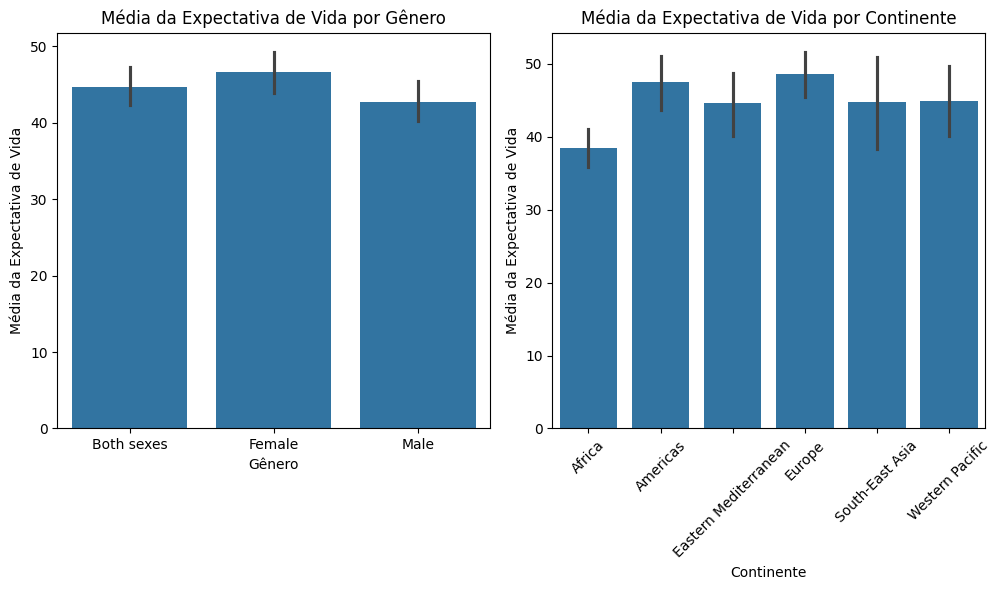

In [273]:

mean_expectativa_vida = df_expectativa_vida[['2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']].mean(axis=1)

# Adicione a média ao dataframe
df_expectativa_vida['mean_expectativa_vida'] = mean_expectativa_vida

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Dim1', y='mean_expectativa_vida', data=df_expectativa_vida)
plt.title('Média da Expectativa de Vida por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Média da Expectativa de Vida')
plt.tight_layout()

plt.subplot(1, 3, 2)
sns.barplot(x='ParentLocation', y='mean_expectativa_vida', data=df_expectativa_vida)
plt.title('Média da Expectativa de Vida por Continente')
plt.xlabel('Continente')
plt.ylabel('Média da Expectativa de Vida')
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()



## 1- Quais continentes do mundo têm visto as maiores melhorias na expectativa de vida ao longo do tempo? 

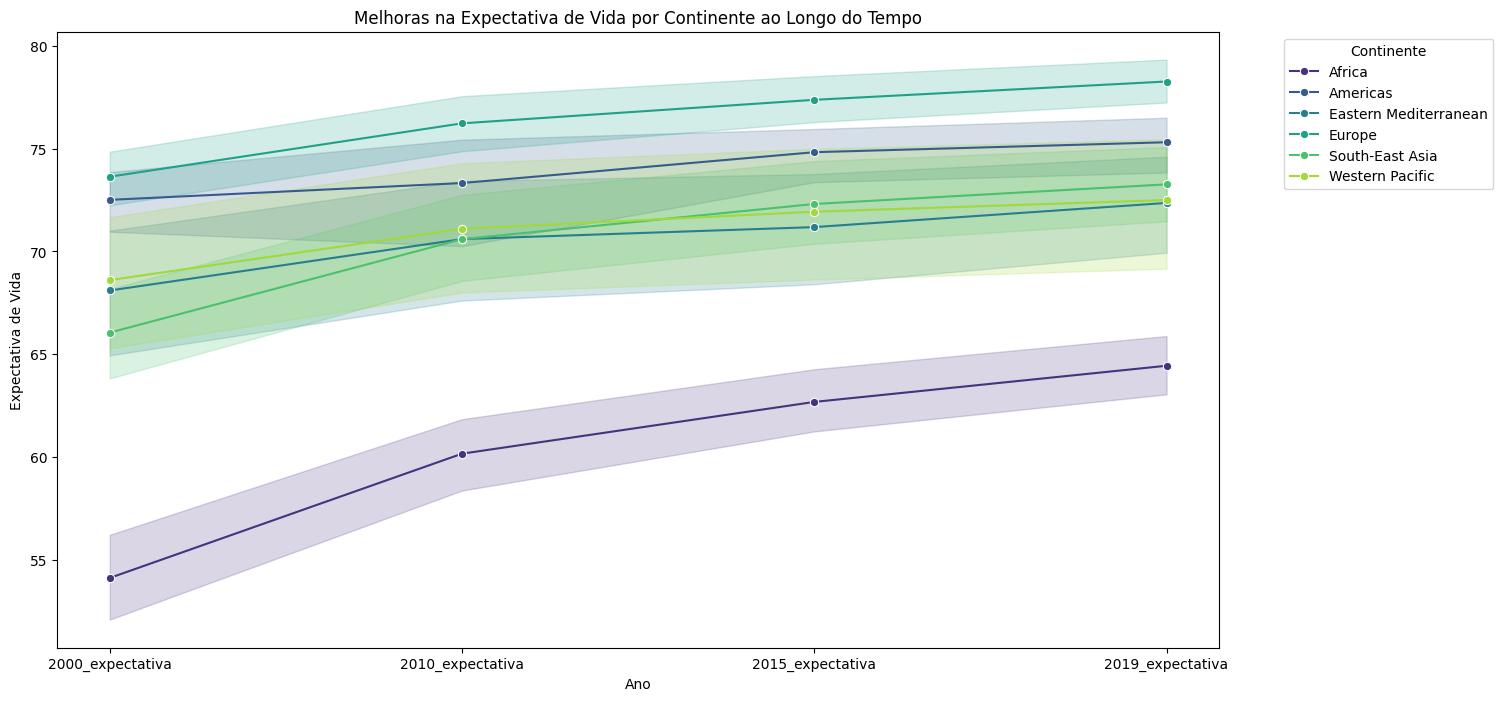

In [274]:

# Filtra o DataFrame para incluir apenas as colunas necessárias
df_melhoras_expectativa = df_expectativa_ao_nascer[['ParentLocation', '2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']]

# Melt para transformar o DataFrame de formato amplo para longo
df_melhoras_expectativa_melted = df_melhoras_expectativa.melt(id_vars='ParentLocation', var_name='Ano', value_name='Expectativa de Vida')

# Plotando o gráfico
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_melhoras_expectativa_melted, x='Ano', y='Expectativa de Vida', hue='ParentLocation', marker='o', palette='viridis')
plt.title('Melhoras na Expectativa de Vida por Continente ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida')
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\rafae\AppData\Local\Temp\ipykernel_4636\3113355922.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rafae\AppData\Local\Temp\ipykernel_4636\3113355922.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Period ParentLocation  2000_expectativa  2010_expectativa  2015_expectativa  \
630            Africa             44.73             56.80             63.04   
564            Africa             43.78             58.60             62.05   
654            Africa             47.51             64.44             67.69   
684            Africa             44.46             56.67             60.50   
678            Africa             48.76             59.67             64.47   

Period  2019_expectativa  razao_2019_2000  
630                65.62         1.467024  
564                63.84         1.458200  
654                69.10         1.454431  
684                62.45         1.404633  
678                66.69         1.367719  


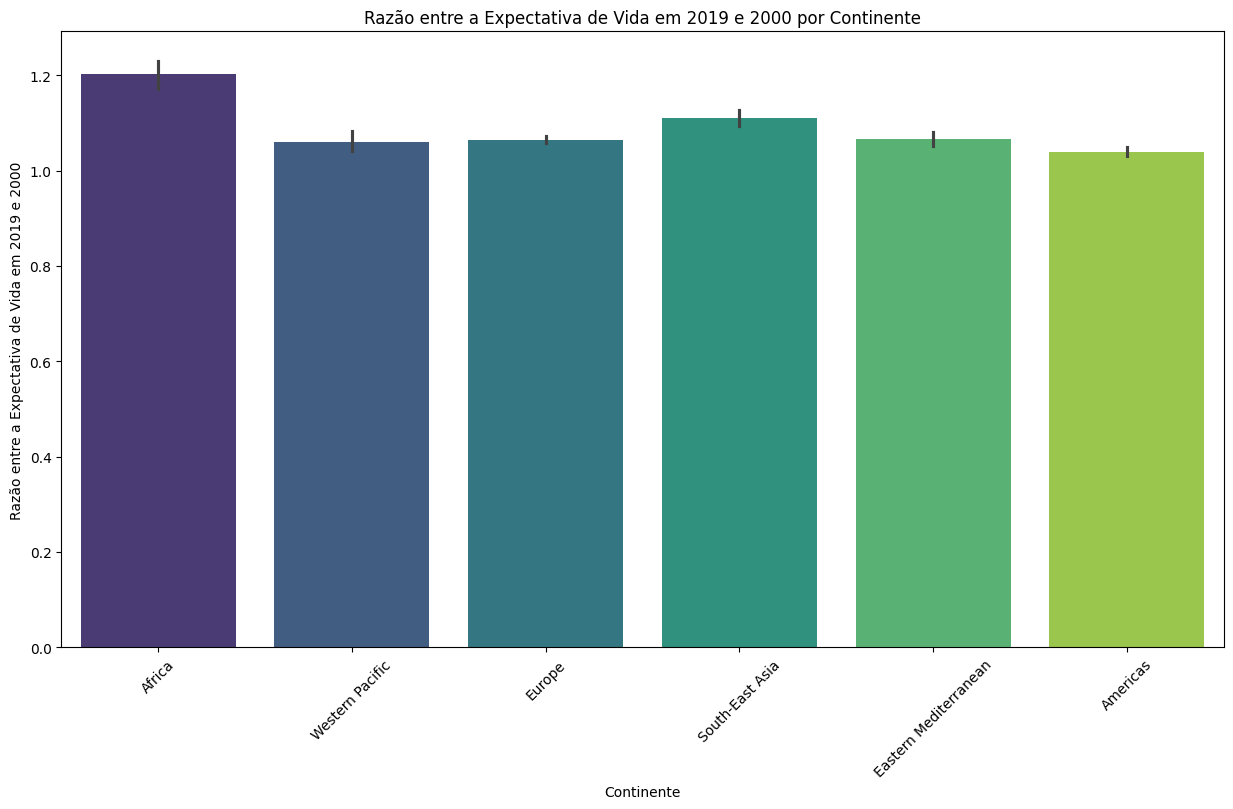

In [275]:
# Compute the reazão entre 2019 e 2000

df_melhoras_expectativa['razao_2019_2000'] = df_melhoras_expectativa['2019_expectativa'] / df_melhoras_expectativa['2000_expectativa']

# Ordena o DataFrame pela razão
df_melhoras_expectativa = df_melhoras_expectativa.sort_values(by='razao_2019_2000', ascending=False)

print(df_melhoras_expectativa.head())

# Plotando o gráfico
plt.figure(figsize=(15, 8))
sns.barplot(data=df_melhoras_expectativa, x='ParentLocation', y='razao_2019_2000', palette='viridis')
plt.title('Razão entre a Expectativa de Vida em 2019 e 2000 por Continente')
plt.xlabel('Continente')
plt.ylabel('Razão entre a Expectativa de Vida em 2019 e 2000')
plt.xticks(rotation=45)
plt.show()


## 2- Qual a predição da expectativa de vida para as próximas décadas em cada país?


## 3 - O IDH afeta na expectativa de vida dos continentes?

1 - Tratando os dados

In [276]:
df_hdi = pd.read_csv('./dataset/hdi.csv', sep=',', encoding='ISO-8859-1')
df_hdi = df_hdi[['Country', 'HDI Rank', '2000','2010', '2015', '2019']]


# Criando o imputer
imputer = SimpleImputer(strategy='mean')

# Preenchendo os valores faltantes com a média
df_hdi['2000'] = imputer.fit_transform(df_hdi[['2000']])
df_hdi['2010'] = imputer.fit_transform(df_hdi[['2010']])
df_hdi['2015'] = imputer.fit_transform(df_hdi[['2015']])
df_hdi['HDI Rank'] = imputer.fit_transform(df_hdi[['HDI Rank']])

df_hdi.head()


,Country,HDI Rank,2000,2010,2015,2019
0,Afghanistan,169.0,0.350,0.472,0.500,0.511
1,Albania,69.0,0.671,0.745,0.788,0.795
2,Algeria,91.0,0.637,0.721,0.740,0.748
3,Andorra,36.0,0.813,0.837,0.862,0.868
4,Angola,148.0,0.400,0.517,0.572,0.581


1.2 Merge dos dados

In [277]:
#df_expectativa_ao_nascer = df_expectativa_ao_nascer.rename(columns={2000: '2000', 2010: 'LifeExp_2010', 2015: 'LifeExp_2015', 2019: 'LifeExp_2019'})
df_hdi = df_hdi.rename(columns={'2000': 'HDI_2000', '2010': 'HDI_2010', '2015': 'HDI_2015', '2019': 'HDI_2019'})

merged_df_12 = pd.merge(df_expectativa_ao_nascer, df_hdi, on='Country', how='inner')

merged_df_12.head()

,Indicator,ParentLocation,Country,Dim1,2000_expectativa,2010_expectativa,2015_expectativa,2019_expectativa,HDI Rank,HDI_2000,HDI_2010,HDI_2015,HDI_2019
0,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637,0.721,0.740,0.748
1,Life expectancy at birth (years),Africa,Angola,Both sexes,49.30,58.07,61.72,63.06,148.0,0.400,0.517,0.572,0.581
2,Life expectancy at birth (years),Africa,Benin,Both sexes,56.59,60.47,61.96,63.43,158.0,0.416,0.494,0.532,0.545
3,Life expectancy at birth (years),Africa,Botswana,Both sexes,45.59,58.14,60.93,62.25,100.0,0.581,0.663,0.717,0.735
4,Life expectancy at birth (years),Africa,Burkina Faso,Both sexes,51.64,58.59,60.92,62.70,182.0,0.293,0.384,0.422,0.452


2 - Correlações


In [278]:
colunas_numericas = ['HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019', '2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']
for coluna in colunas_numericas:
    merged_df_12[coluna] = pd.to_numeric(merged_df_12[coluna], errors='coerce')

# Agora verifique os tipos de dados para garantir que as conversões foram bem-sucedidas
print(merged_df_12.dtypes)

Indicator            object
ParentLocation       object
Country              object
Dim1                 object
2000_expectativa    float64
2010_expectativa    float64
2015_expectativa    float64
2019_expectativa    float64
HDI Rank            float64
HDI_2000            float64
HDI_2010            float64
HDI_2015            float64
HDI_2019            float64
dtype: object


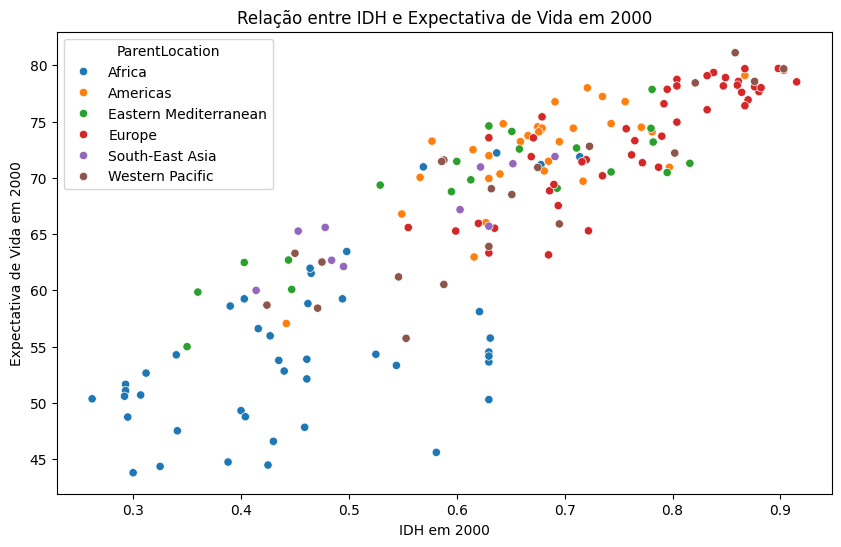

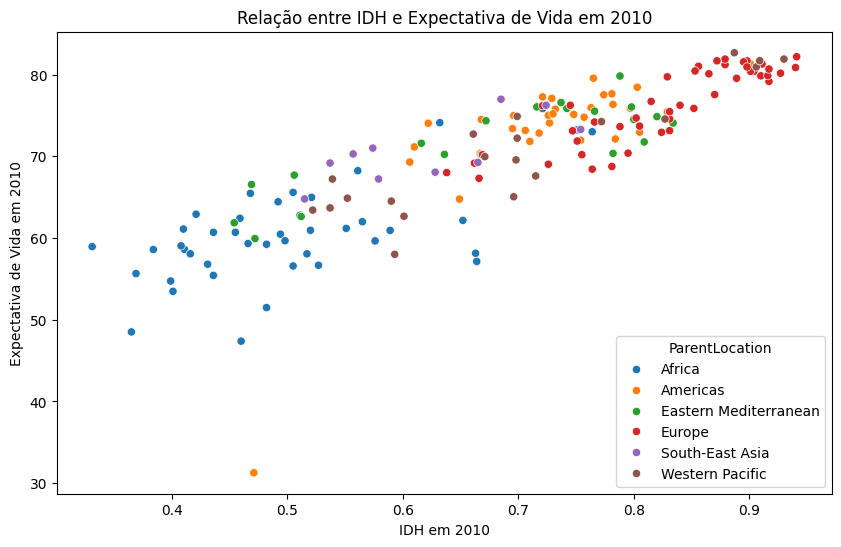

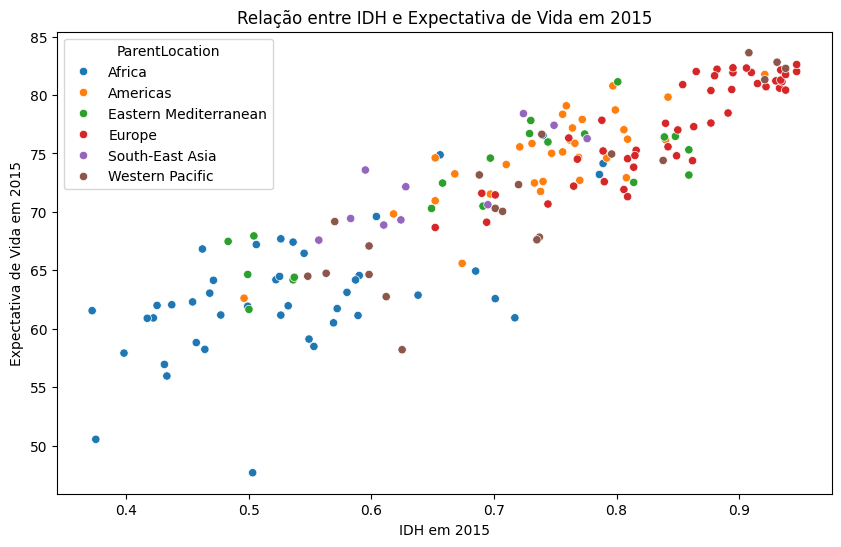

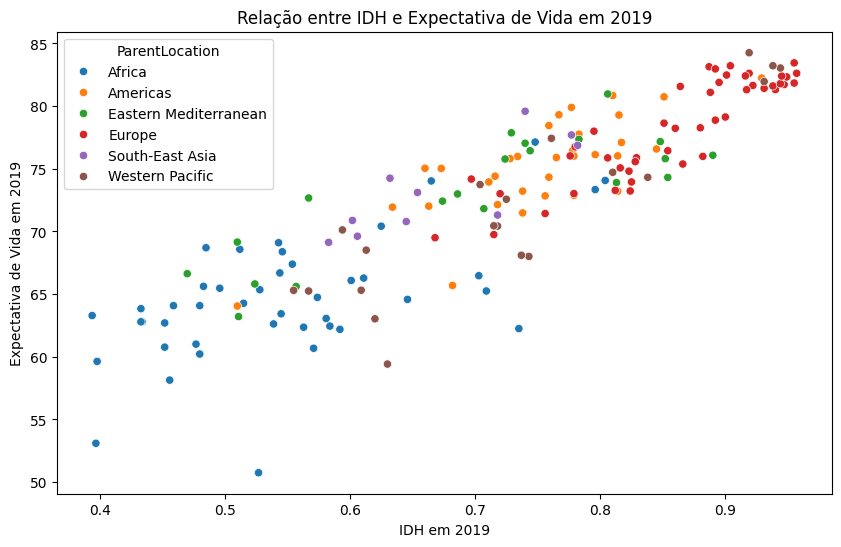

Correlação Pearson entre IDH e Expectativa de Vida em 2000: 0.8567852415610642, P-valor: 1.7575010177916286e-50
Correlação Pearson entre IDH e Expectativa de Vida em 2010: 0.8686209791382845, P-valor: 2.0262513010699705e-53
Correlação Pearson entre IDH e Expectativa de Vida em 2015: 0.8914429877640025, P-valor: 5.479336672991734e-60
Correlação Pearson entre IDH e Expectativa de Vida em 2019: 0.8877753511563753, P-valor: 7.738022300951482e-59


In [279]:

# Calcular as médias por ParentLocation (que pode ser continente ou região)
mean_values = merged_df_12.groupby('ParentLocation')[['HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019']].mean()


# Visualização de Dados - Gráficos de Dispersão
for year in ['2000', '2010', '2015', '2019']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'HDI_{year}', y=f'{year}_expectativa', hue='ParentLocation', data=merged_df_12)
    plt.title(f'Relação entre IDH e Expectativa de Vida em {year}')
    plt.xlabel(f'IDH em {year}')
    plt.ylabel(f'Expectativa de Vida em {year}')
    plt.show()

# Análise Estatística - Teste de Correlação
for year in ['2000', '2010', '2015', '2019']:
    correlation, p_value = pearsonr(merged_df_12[f'HDI_{year}'], merged_df_12[f'{year}_expectativa'])
    print(f"Correlação Pearson entre IDH e Expectativa de Vida em {year}: {correlation}, P-valor: {p_value}")


HDI_2000            float64
HDI_2010            float64
HDI_2015            float64
HDI_2019            float64
2000_expectativa    float64
2010_expectativa    float64
2015_expectativa    float64
2019_expectativa    float64
dtype: object


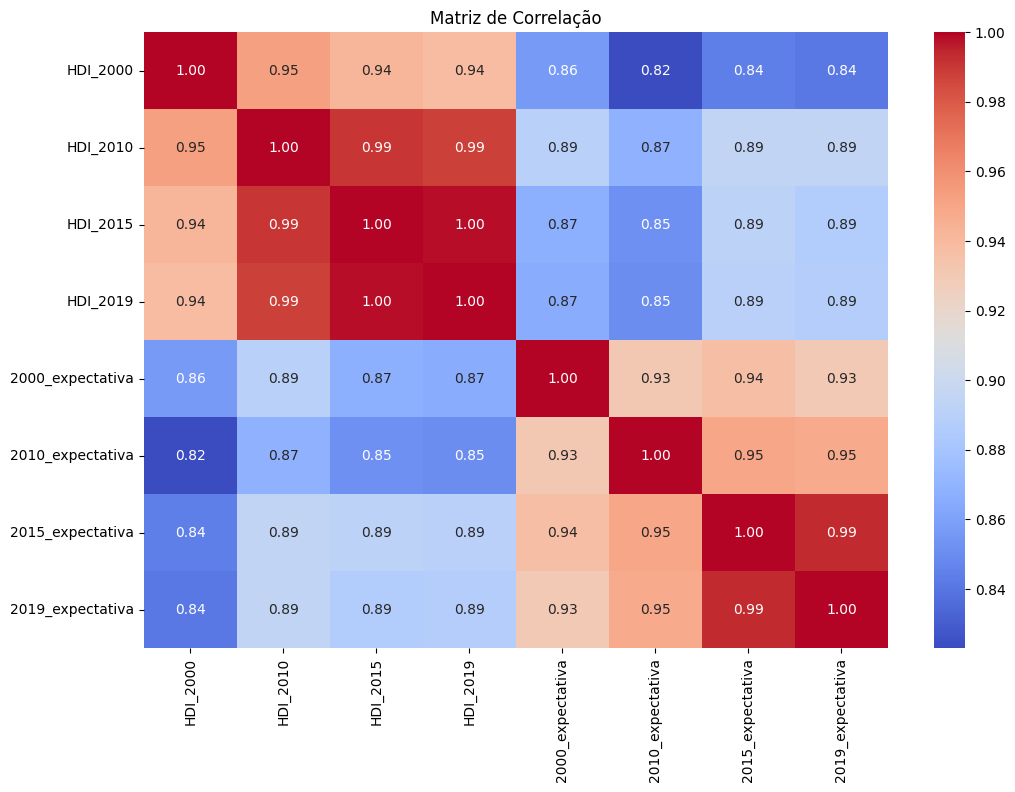

In [281]:
colunas_numericas = ['HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019', '2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']
for coluna in colunas_numericas:
    merged_df_12[coluna] = pd.to_numeric(merged_df_12[coluna], errors='coerce')

# Verificando os tipos de dados
print(merged_df_12[colunas_numericas].dtypes)

# Calculando a matriz de correlação
matriz_correlacao = merged_df_12[colunas_numericas].corr()

# Visualizando a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Correlações Fortes entre HDI e Expectativa de Vida:

Os coeficientes de correlação entre os valores de HDI e expectativa de vida para os anos correspondentes são todos positivos e fortes, variando aproximadamente entre 0.82 e 0.89. Isso indica uma forte relação positiva, sugerindo que países com um HDI mais alto tendem a ter uma expectativa de vida maior.
Correlações ao Longo do Tempo:

A correlação entre os diferentes anos de HDI é muito alta (entre 0.94 e 1.00), indicando que os valores de HDI são consistentes ao longo do tempo e que o desenvolvimento humano de um país tende a permanecer estável ou a melhorar de forma constante.
Consistência na Expectativa de Vida:

Similarmente, a expectativa de vida ao longo dos anos também mostra uma alta correlação (entre 0.93 e 1.00), o que sugere que a expectativa de vida nos países permaneceu relativamente estável ou melhorou ao longo dos anos considerados.
Correlações entre HDI e Expectativa de Vida em Anos Diferentes:

Existe uma correlação um pouco menor, mas ainda forte, entre os valores de HDI e expectativa de vida de anos diferentes. Por exemplo, o HDI de 2000 ainda mostra uma correlação forte com a expectativa de vida em 2019, o que pode indicar que o progresso no desenvolvimento humano tem um efeito duradouro sobre a expectativa de vida de uma população.
Em resumo, esta matriz de correlação confirma que existe uma relação positiva e robusta entre o HDI e a expectativa de vida ao longo do tempo. Os valores consistentemente altos de correlação entre os diferentes anos para ambas as variáveis indicam que tanto o desenvolvimento humano quanto a expectativa de vida melhoram em conjunto e que essa melhoria é sustentável ao longo do tempo. Isso reforça a importância de políticas e intervenções voltadas para o desenvolvimento humano, pois elas têm o potencial de impactar positivamente a expectativa de vida.

2.1 Intervalos de Confiança para media da Expectativa de vida e IDH

In [282]:
def calcular_intervalo_confianca(data):
    n = len(data)
    media = np.mean(data)
    sem = stats.sem(data)  
    intervalo = stats.t.interval(0.95, df=n-1, loc=media, scale=sem)  # Intervalo de confiança de 95%
    return intervalo

# Dicionário para armazenar os intervalos de confiança
intervalos_confianca = {}

# Calcular o intervalo de confiança para cada coluna numérica
for coluna in colunas_numericas:
    data = merged_df_12[coluna].dropna()  # Remover valores NA/NaN para o cálculo
    intervalos_confianca[coluna] = calcular_intervalo_confianca(data)

# Exibir os intervalos de confiança
for coluna, intervalo in intervalos_confianca.items():
    print(f"Intervalo de confiança de 95% para a média de {coluna}: {intervalo}")

Intervalo de confiança de 95% para a média de HDI_2000: (0.6042773748444394, 0.6532629574678226)
Intervalo de confiança de 95% para a média de HDI_2010: (0.6594778369766606, 0.7064402916783102)
Intervalo de confiança de 95% para a média de HDI_2015: (0.6832311074661954, 0.7288624597852664)
Intervalo de confiança de 95% para a média de HDI_2019: (0.6953355754799666, 0.7405357695492731)
Intervalo de confiança de 95% para a média de 2000_expectativa: (65.53470307228591, 68.45149575812346)
Intervalo de confiança de 95% para a média de 2010_expectativa: (68.93160878711755, 71.50710466317484)
Intervalo de confiança de 95% para a média de 2015_expectativa: (70.53566036743892, 72.78738056823362)
Intervalo de confiança de 95% para a média de 2019_expectativa: (71.61088007784444, 73.71742401572281)


O intervalo de confiança para o HDI aumentou progressivamente de 2000 a 2019, o que sugere uma melhoria geral no desenvolvimento humano durante esse período. Em 2000, o intervalo de confiança da média do HDI estava entre 0.604 e 0.653, e em 2019, este intervalo aumentou para 0.695 a 0.741. Essa mudança sugere um desenvolvimento positivo e consistente.
Expectativa de Vida ao Longo do Tempo:

Similarmente, os intervalos de confiança para a expectativa de vida também mostram um aumento consistente, indicando uma melhoria na longevidade das populações. Em 2000, a expectativa de vida média estava entre aproximadamente 65.5 e 68.5 anos, enquanto em 2019, esse intervalo aumentou para 71.6 a 73.7 anos.
Comparação entre HDI e Expectativa de Vida:

A tendência de aumento tanto no HDI quanto na expectativa de vida sugere que os dois indicadores estão possivelmente correlacionados. Países que conseguem melhorar o seu desenvolvimento humano geralmente também veem melhorias na expectativa de vida dos seus cidadãos.

### Regressão Linear

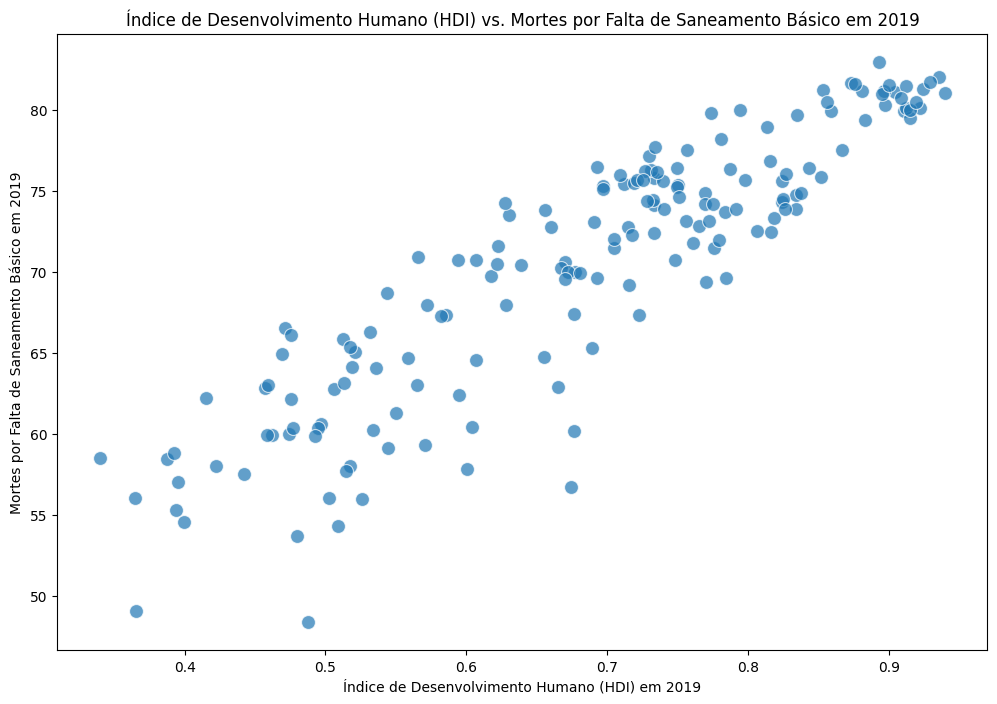

In [283]:
#anos_interesse = [2000, 2010, 2015, 2019]
df_anos_interesse = merged_df_12
df_anos_interesse['Media_LifeExp'] = merged_df_12[['2000_expectativa', '2010_expectativa', '2015_expectativa', '2019_expectativa']].mean(axis=1)
df_anos_interesse['Media_HDI'] = merged_df_12[['HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019']].mean(axis=1)



# Crie o gráfico de dispersão.
plt.figure(figsize=(12, 8))

# Use o método scatter do matplotlib para criar o gráfico.
scatter = sns.scatterplot(x='Media_HDI', y='Media_LifeExp', data=df_anos_interesse, s=100, alpha=0.7)

# Defina os rótulos dos eixos e o título.
plt.title('Índice de Desenvolvimento Humano (HDI) vs. Mortes por Falta de Saneamento Básico em 2019')
plt.xlabel('Índice de Desenvolvimento Humano (HDI) em 2019')
plt.ylabel('Mortes por Falta de Saneamento Básico em 2019')

# Exiba o gráfico.
plt.show()

In [284]:

X = df_anos_interesse['Media_LifeExp'].values.reshape(-1,1) # Variáveis independentes
y = df_anos_interesse['Media_HDI'].values.reshape(-1,1) # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Adicionando uma constante ao modelo
X = sm.add_constant(X_scaled)

# Criando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibindo os resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     695.1
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           8.94e-62
Time:                        14:59:02   Log-Likelihood:                 218.66
No. Observations:                 171   AIC:                            -433.3
Df Residuals:                     169   BIC:                            -427.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6839      0.005    131.983      0.0

In [285]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Criando o modelo de regressão linear
modelo = LinearRegression()

# Ajustando o modelo aos dados de treino
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# Inicializando a lista para armazenar os MSEs
mse_list = []
mae_bootstrap = []  # Lista para armazenar os MAEs de cada reamostragem

# Número de iterações de bootstrap
n_bootstrap = 1000

for _ in range(n_bootstrap):
    # Bootstrap sample
    indices = np.random.choice(len(X_train), len(X_train), replace=True)
    X_train_bs = X_train[indices]
    y_train_bs = y_train[indices]

    # Ajustando o modelo
    modelo_bs = LinearRegression().fit(X_train_bs, y_train_bs)

    # Fazendo previsões no conjunto de teste
    y_pred_bs = modelo_bs.predict(X_test)

    # Calculando e armazenando o MSE
    mse = mean_squared_error(y_test, y_pred_bs)
    mse_list.append(mse)

    mae_bootstrap.append(mean_absolute_error(y_test, y_pred_bs))



lower_bound = np.percentile(mae_bootstrap, 2.5)
upper_bound = np.percentile(mae_bootstrap, 97.5)
# Calculando o intervalo de confiança para o MSE
lower = np.percentile(mse_list, 2.5)
upper = np.percentile(mse_list, 97.5)

# Bootstrap

print(f'Coefficient: {modelo.coef_[0][1]}')
print(f'Intercept: {modelo.intercept_}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):}' )
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred):}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f"Intervalo de Confiança de 95% para o MAE: {lower:}, {upper:}")
print(f"Intervalo de confiança de 95% para o MAE: [{lower_bound:.2f}, {upper_bound:.2f}]")




Coefficient: 0.13433951601135943
Intercept: [0.6827972]
Mean squared error: 0.004305029155463548
Mean absolute error: 0.05477792984133261
R2: 0.85
Intervalo de Confiança de 95% para o MAE: 0.004248725328264204, 0.004896525407925284
Intervalo de confiança de 95% para o MAE: [0.05, 0.06]


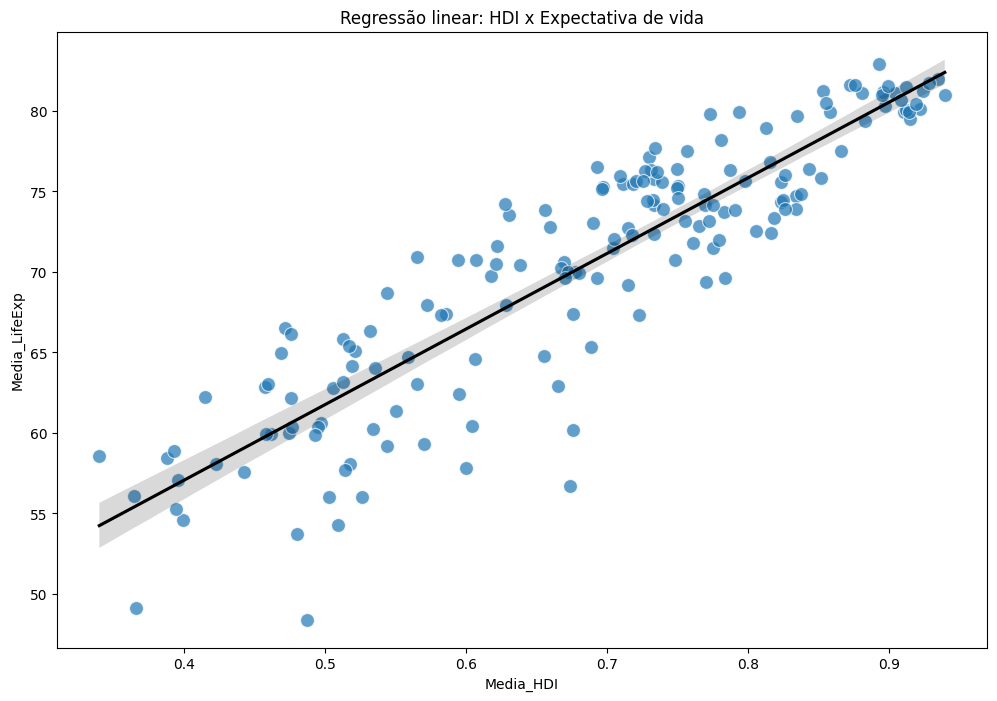

In [286]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Media_HDI', y='Media_LifeExp', data=df_anos_interesse, s=100, alpha=0.7)
# Agora, adicione uma linha de regressão geral (sem coloração por 'Death')
sns.regplot(x='Media_HDI', y='Media_LifeExp', data=df_anos_interesse, scatter=False, color='black')
plt.title('Regressão linear: HDI x Expectativa de vida')
plt.show()

O que os resultados acima pode nos dizer?


A análise das métricas de correlação entre o Índice de Desenvolvimento Humano (HDI) e a expectativa de vida revela várias informações importantes:

Coeficiente (0.1343): O coeficiente da regressão linear é relativamente baixo, indicando que, enquanto o HDI tem uma relação positiva com a expectativa de vida (ou seja, um aumento no HDI tende a estar associado a um aumento na expectativa de vida), essa relação não é muito forte.

Intercepto (0.6828): O valor do intercepto sugere que, quando o HDI é 0 (o que teoricamente representa o nível mais baixo de desenvolvimento humano), a expectativa de vida estimada é de aproximadamente 0.683 anos. Este valor, contudo, é mais teórico do que prático, já que o HDI raramente é 0.

Erro Quadrático Médio (MSE) (0.0043): O MSE é bastante baixo, o que sugere que o modelo se ajusta bem aos dados. No entanto, é importante notar que o MSE depende da escala das variáveis e, portanto, deve ser interpretado no contexto dessas escalas.

Erro Absoluto Médio (MAE) (0.0548): O MAE também é baixo, indicando que as previsões do modelo geralmente não estão muito distantes dos valores reais. O intervalo de confiança de 95% para o MAE (0.05 a 0.06) reforça essa interpretação, mostrando que a incerteza em torno do MAE é limitada.

Coeficiente de Determinação (R²) (0.85): O valor de R² é bastante alto, sugerindo que o modelo explica uma grande proporção da variância nos dados. Isso significa que o HDI é um bom preditor da expectativa de vida, pelo menos dentro do contexto deste modelo e dos dados utilizados.

Intervalos de Confiança para o MAE: Há dois intervalos de confiança fornecidos para o MAE. O primeiro (0.0042 a 0.0049) é muito estreito, o que sugere uma alta precisão nas previsões do modelo. O segundo intervalo (0.05 a 0.06) é mais amplo e provavelmente representa uma escala diferente (possivelmente após a reescala dos dados). Ambos indicam uma boa consistência nas previsões do modelo.

Em resumo, o modelo de regressão linear indica que há uma relação positiva entre o HDI e a expectativa de vida, com o modelo sendo capaz de explicar uma grande parte da variação na expectativa de vida. O baixo erro nas previsões sugere que o modelo é confiável, embora o coeficiente relativamente baixo indique que outros fatores além do HDI também desempenham papéis significativos na determinação da expectativa de vida.

# 4 - Quais aspectos (social, saúde, ambiental e econômicos) influenciam mais na expectativa de vida por países?

## Análise Aspectos Saúde: Tabaco!

## Tratando os dados

In [287]:

# Carregar o DataFrame a partir do arquivo CSV
df_tabaco = pd.read_csv('./dataset/tobacco_prevalence.csv')

# Selecionar colunas relevantes
df_tabaco = df_tabaco[['Indicator', 'ParentLocation', 'Location', 'Dim1','Period', 'Value']]

# Renomear as colunas
df_tabaco.columns = ['Indicator', 'ParentLocation', 'Country', 'Dim1', 'Year', 'Value']
df_tabaco = df_tabaco[df_tabaco['Year'].isin([2000, 2010, 2015, 2019])]

# Pivotear a coluna 'Year' para 4 colunas com os anos e seus respectivos valores
df_tabaco = df_tabaco.pivot(index=['Indicator', 'ParentLocation', 'Country', 'Dim1'], columns='Year', values='Value')

# Redefinir o índice
df_tabaco = df_tabaco.reset_index()

# Renomear as colunas
df_tabaco.columns.name = None

# Renomear as colunas dos anos
df_tabaco = df_tabaco.rename(columns={2000: '2000_tabaco', 2010: '2010_tabaco', 2015: '2015_tabaco', 2019: '2019_tabaco'})

# Visualizar o DataFrame pivoteado
df_tabaco.head()


,Indicator,ParentLocation,Country,Dim1,2000_tabaco,2010_tabaco,2015_tabaco,2019_tabaco
0,Estimate of current tobacco smoking prevalence...,Africa,Algeria,Both sexes,16.2,15.6,15.4,15.2
1,Estimate of current tobacco smoking prevalence...,Africa,Algeria,Female,1.7,1.0,0.8,0.6
2,Estimate of current tobacco smoking prevalence...,Africa,Algeria,Male,30.7,30.2,29.9,29.7
3,Estimate of current tobacco smoking prevalence...,Africa,Benin,Both sexes,11.0,7.2,5.8,4.9
4,Estimate of current tobacco smoking prevalence...,Africa,Benin,Female,1.9,1.5,1.3,1.2


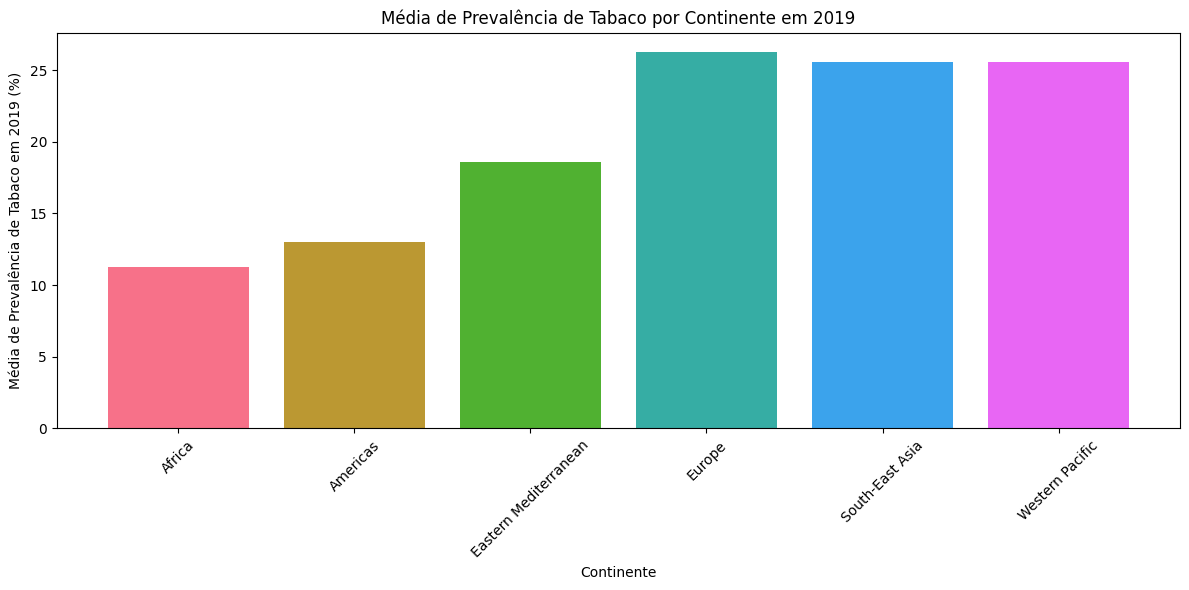

In [288]:

# Filtrar os dados para 2019 e por continente
df_2019_continents = df_tabaco[df_tabaco['ParentLocation'] != 'Global']
df_2019_continents = df_2019_continents[['Country', '2019_tabaco', 'ParentLocation']]

# Agrupar por continente e calcular a média da prevalência de tabaco em 2019
df_2019_avg_by_continent = df_2019_continents.groupby('ParentLocation')['2019_tabaco'].mean().reset_index()

# Definir uma paleta de cores
colors = sns.color_palette('husl', n_colors=len(df_2019_avg_by_continent))

# Plotar o gráfico de barras com cores distintas para cada continente
plt.figure(figsize=(12, 6))
plt.bar(df_2019_avg_by_continent['ParentLocation'], df_2019_avg_by_continent['2019_tabaco'], color=colors)
plt.xlabel('Continente')
plt.ylabel('Média de Prevalência de Tabaco em 2019 (%)')
plt.title('Média de Prevalência de Tabaco por Continente em 2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


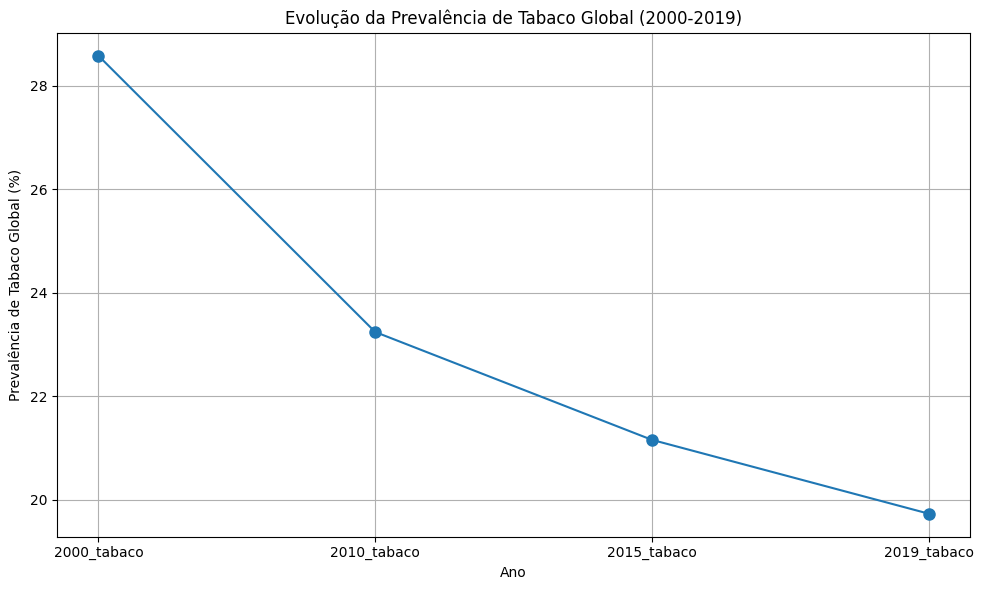

In [289]:
# Calcular a média global da prevalência de tabaco ao longo dos anos
global_prevalence = df_tabaco[['2000_tabaco', '2010_tabaco', '2015_tabaco', '2019_tabaco']].mean()

# Plotar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(global_prevalence.index, global_prevalence.values, marker='o', linestyle='-', markersize=8)
plt.xlabel('Ano')
plt.ylabel('Prevalência de Tabaco Global (%)')
plt.title('Evolução da Prevalência de Tabaco Global (2000-2019)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Corelacionando os dados

In [290]:
# Realizar a junção dos DataFrames utilizando as colunas-chave 'Country', 'ParentLocation' e 'Dim1'
df_exp_nasc_e_tabaco = df_tabaco.merge(df_expectativa_ao_nascer, on=['Country', 'ParentLocation', 'Dim1'], how='inner')

df_exp_nasc_e_tabaco = df_exp_nasc_e_tabaco.drop(columns=['Indicator_y'])

df_exp_nasc_e_tabaco = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['Indicator_x'] == 'Estimate of current tobacco use prevalence (%) (age-standardized rate)']
# Visualizar o DataFrame resultante
df_exp_nasc_e_tabaco.head()



,Indicator_x,ParentLocation,Country,Dim1,2000_tabaco,2010_tabaco,2015_tabaco,2019_tabaco,2000_expectativa,2010_expectativa,2015_expectativa,2019_expectativa
1,Estimate of current tobacco use prevalence (%)...,Africa,Algeria,Both sexes,22.2,21.5,21.1,21.0,72.21,75.85,76.54,77.13
3,Estimate of current tobacco use prevalence (%)...,Africa,Benin,Both sexes,16.7,10.7,8.6,7.2,56.59,60.47,61.96,63.43
5,Estimate of current tobacco use prevalence (%)...,Africa,Botswana,Both sexes,33.2,24.8,21.7,19.8,45.59,58.14,60.93,62.25
7,Estimate of current tobacco use prevalence (%)...,Africa,Burkina Faso,Both sexes,29.8,20.5,17.0,14.9,51.64,58.59,60.92,62.70
9,Estimate of current tobacco use prevalence (%)...,Africa,Burundi,Both sexes,24.0,16.6,13.9,12.2,43.78,58.60,62.05,63.84


Análise Descritiva:

In [291]:
# Etapa 1: Análise Descritiva

# Estatísticas descritivas da prevalência de tabaco
desc_tabaco = df_exp_nasc_e_tabaco.filter(like='_tabaco').describe()

# Estatísticas descritivas da expectativa de vida ao nascer
desc_expectativa = df_exp_nasc_e_tabaco.filter(like='_expectativa').describe()

# Organize o output
desc_tabaco = desc_tabaco.transpose()
desc_tabaco.index = [int(col.split('_')[0]) for col in desc_tabaco.index]
desc_tabaco.columns = ['Contagem', 'Média', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']

desc_expectativa = desc_expectativa.transpose()
desc_expectativa.index = [int(col.split('_')[0]) for col in desc_expectativa.index]
desc_expectativa.columns = ['Contagem', 'Média', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']

desc_tabaco, desc_expectativa


(      Contagem      Média  Desvio Padrão  Mínimo     25%   50%     75%  Máximo
 2000     158.0  29.667089      12.384598     6.8  20.700  29.8  36.225    68.5
 2010     158.0  24.031013      10.350432     4.9  15.650  24.8  30.750    54.6
 2015     158.0  21.826582       9.857859     4.2  13.525  22.4  28.050    48.8
 2019     158.0  20.324051       9.622164     3.6  12.100  20.7  26.125    45.1,
       Contagem      Média  Desvio Padrão  Mínimo      25%     50%      75%  \
 2000     158.0  67.078671       9.923619   43.78  60.0125  70.720  74.5225   
 2010     158.0  70.398038       8.843677   31.28  64.5825  72.950  76.6875   
 2015     158.0  72.051139       7.598984   47.67  66.5425  73.225  77.8125   
 2019     158.0  73.066139       7.086252   50.75  67.3525  74.125  78.4875   
 
       Máximo  
 2000   81.12  
 2010   82.68  
 2015   83.62  
 2019   84.26  )

Visualização da relação:


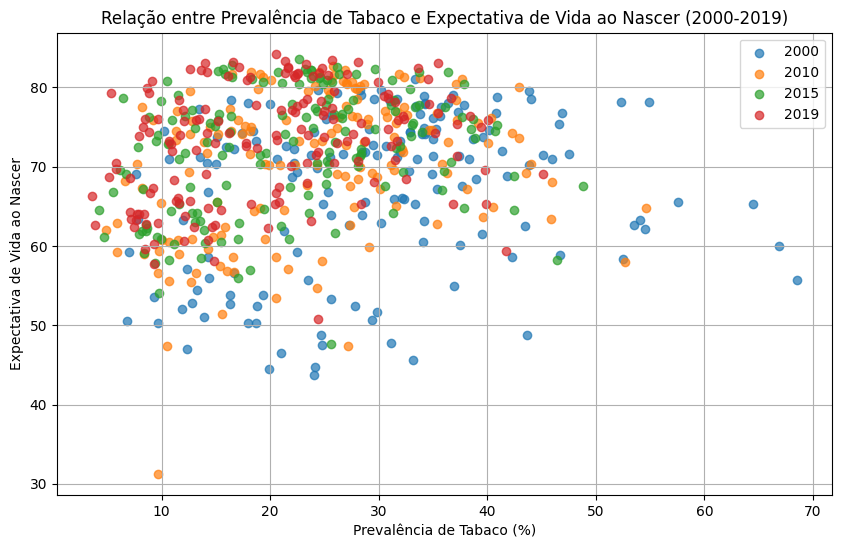

In [292]:
# Etapa 2: Visualização da Relação

plt.figure(figsize=(10, 6))
years = [2000, 2010, 2015, 2019]

for year in years:
    plt.scatter(df_exp_nasc_e_tabaco[f'{year}_tabaco'], df_exp_nasc_e_tabaco[f'{year}_expectativa'], alpha=0.7, label=year)

plt.xlabel('Prevalência de Tabaco (%)')
plt.ylabel('Expectativa de Vida ao Nascer')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida ao Nascer (2000-2019)')
plt.legend()
plt.grid(True)
plt.show()


### **Etapa 3: Teste de Hipótese**

Para realizar um teste de hipótese, você definiremos uma hipótese nula (H0) e uma hipótese alternativa (H1) com base na pergunta de pesquisa. Vamos supor que você deseja testar se a média da expectativa de vida ao nascer é diferente entre os anos de 2000 e 2019 para os grupos com alta e baixa prevalência de tabaco.
#### Teste de Hipótese para todos os anos

Nas próximas células, realizaremos um teste t independente para comparar as médias de expectativa de vida entre grupos com alta e baixa prevalência de tabaco de 2000, 2010, 2015 e 2019 e informaremos qual hipótese foi aceita.

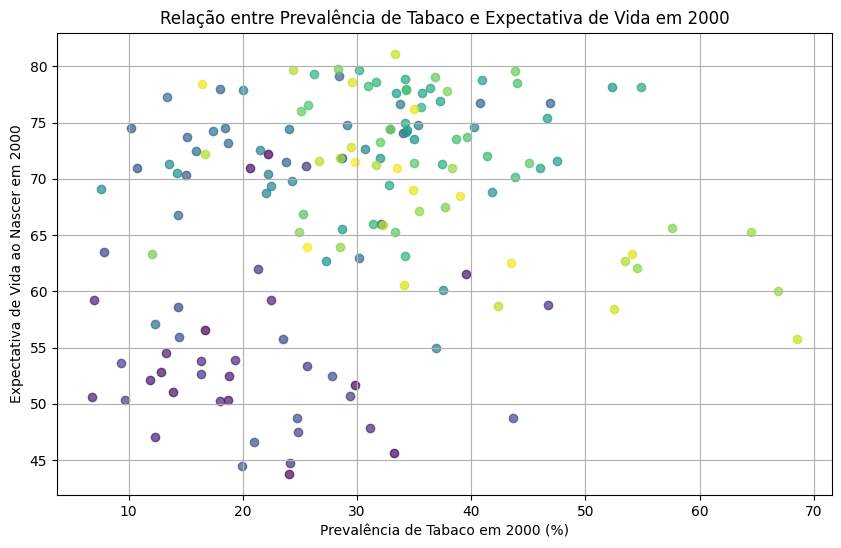

(3.7813685228086933, 0.0002217165389297721, 'Rejeitar a hipótese nula')

In [293]:
# Teste de Hipótese para 2000
tabaco_alto_2000 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2000_tabaco'] >= df_exp_nasc_e_tabaco['2000_tabaco'].median()]
tabaco_baixo_2000 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2000_tabaco'] < df_exp_nasc_e_tabaco['2000_tabaco'].median()]

t_stat_2000, p_value_2000 = stats.ttest_ind(tabaco_alto_2000['2000_expectativa'], tabaco_baixo_2000['2000_expectativa'])

# Aceitar ou rejeitar a hipótese nula com base no valor de p
alpha = 0.05  # Nível de significância de 0.05

if p_value_2000 < alpha:
    conclusao_2000 = "Rejeitar a hipótese nula"
else:
    conclusao_2000 = "Aceitar a hipótese nula"

# Cores diferentes para cada país
unique_countries = df_exp_nasc_e_tabaco['Country'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_countries)))

# Gráfico de Dispersão para 2000 com cores diferentes para cada país
plt.figure(figsize=(10, 6))
for i, country in enumerate(unique_countries):
    country_data = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['Country'] == country]
    plt.scatter(country_data['2000_tabaco'], country_data['2000_expectativa'], alpha=0.7, label=country, color=colors[i])

plt.xlabel('Prevalência de Tabaco em 2000 (%)')
plt.ylabel('Expectativa de Vida ao Nascer em 2000')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida em 2000')
plt.grid(True)
plt.show()

t_stat_2000, p_value_2000, conclusao_2000


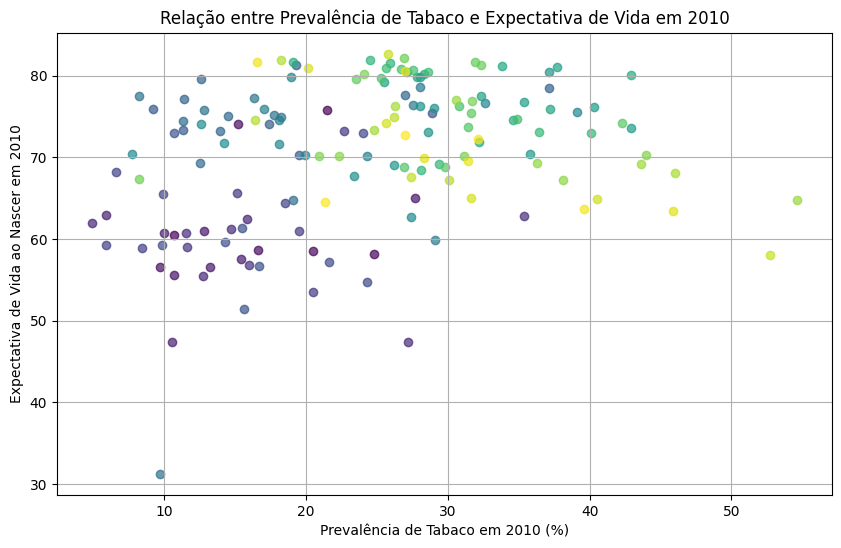

(4.375710621455829, 2.20593335167292e-05, 'Rejeitar a hipótese nula')

In [294]:
# Teste de Hipótese para 2010
tabaco_alto_2010 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2010_tabaco'] >= df_exp_nasc_e_tabaco['2010_tabaco'].median()]
tabaco_baixo_2010 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2010_tabaco'] < df_exp_nasc_e_tabaco['2010_tabaco'].median()]

t_stat_2010, p_value_2010 = stats.ttest_ind(tabaco_alto_2010['2010_expectativa'], tabaco_baixo_2010['2010_expectativa'])

# Aceitar ou rejeitar a hipótese nula com base no valor de p
alpha = 0.05  # Nível de significância de 0.05

if p_value_2010 < alpha:
    conclusao_2010 = "Rejeitar a hipótese nula"
else:
    conclusao_2010 = "Aceitar a hipótese nula"

# Cores diferentes para cada país
unique_countries = df_exp_nasc_e_tabaco['Country'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_countries)))

# Gráfico de Dispersão para 2010 com cores diferentes para cada país
plt.figure(figsize=(10, 6))
for i, country in enumerate(unique_countries):
    country_data = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['Country'] == country]
    plt.scatter(country_data['2010_tabaco'], country_data['2010_expectativa'], alpha=0.7, label=country, color=colors[i])

plt.xlabel('Prevalência de Tabaco em 2010 (%)')
plt.ylabel('Expectativa de Vida ao Nascer em 2010')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida em 2010')
plt.grid(True)
plt.show()

t_stat_2010, p_value_2010, conclusao_2010


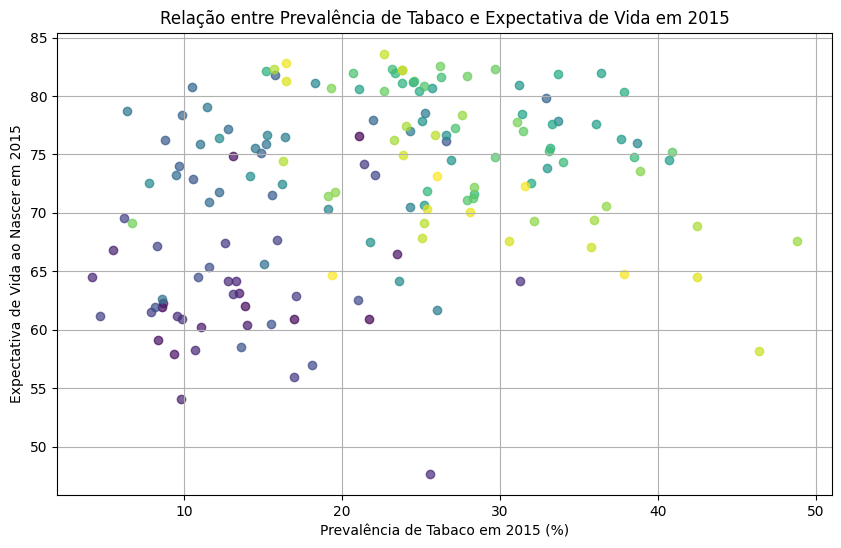

(4.40138569736383, 1.9860269377312265e-05, 'Rejeitar a hipótese nula')

In [295]:
# Teste de Hipótese para 2015
tabaco_alto_2015 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2015_tabaco'] >= df_exp_nasc_e_tabaco['2015_tabaco'].median()]
tabaco_baixo_2015 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2015_tabaco'] < df_exp_nasc_e_tabaco['2015_tabaco'].median()]

t_stat_2015, p_value_2015 = stats.ttest_ind(tabaco_alto_2015['2015_expectativa'], tabaco_baixo_2015['2015_expectativa'])

# Aceitar ou rejeitar a hipótese nula com base no valor de p
alpha = 0.05  # Nível de significância de 0.05

if p_value_2015 < alpha:
    conclusao_2015 = "Rejeitar a hipótese nula"
else:
    conclusao_2015 = "Aceitar a hipótese nula"

# Cores diferentes para cada país
unique_countries = df_exp_nasc_e_tabaco['Country'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_countries)))

# Gráfico de Dispersão para 2015 com cores diferentes para cada país
plt.figure(figsize=(10, 6))
for i, country in enumerate(unique_countries):
    country_data = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['Country'] == country]
    plt.scatter(country_data['2015_tabaco'], country_data['2015_expectativa'], alpha=0.7, label=country, color=colors[i])

plt.xlabel('Prevalência de Tabaco em 2015 (%)')
plt.ylabel('Expectativa de Vida ao Nascer em 2015')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida em 2015')
plt.grid(True)
plt.show()

t_stat_2015, p_value_2015, conclusao_2015


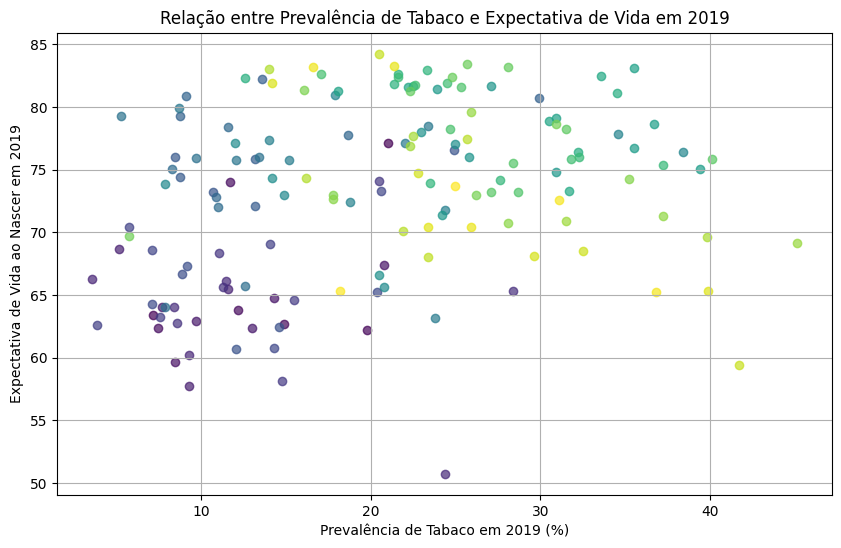

(4.237649499852205, 3.851419992759614e-05, 'Rejeitar a hipótese nula')

In [296]:
# Teste de Hipótese para 2019
tabaco_alto_2019 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2019_tabaco'] >= df_exp_nasc_e_tabaco['2019_tabaco'].median()]
tabaco_baixo_2019 = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['2019_tabaco'] < df_exp_nasc_e_tabaco['2019_tabaco'].median()]

t_stat_2019, p_value_2019 = stats.ttest_ind(tabaco_alto_2019['2019_expectativa'], tabaco_baixo_2019['2019_expectativa'])

# Aceitar ou rejeitar a hipótese nula com base no valor de p
alpha = 0.05  # Nível de significância de 0.05

if p_value_2019 < alpha:
    conclusao_2019 = "Rejeitar a hipótese nula"
else:
    conclusao_2019 = "Aceitar a hipótese nula"

# Cores diferentes para cada país
unique_countries = df_exp_nasc_e_tabaco['Country'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_countries)))

# Gráfico de Dispersão para 2019 com cores diferentes para cada país
plt.figure(figsize=(10, 6))
for i, country in enumerate(unique_countries):
    country_data = df_exp_nasc_e_tabaco[df_exp_nasc_e_tabaco['Country'] == country]
    plt.scatter(country_data['2019_tabaco'], country_data['2019_expectativa'], alpha=0.7, label=country, color=colors[i])

plt.xlabel('Prevalência de Tabaco em 2019 (%)')
plt.ylabel('Expectativa de Vida ao Nascer em 2019')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida em 2019')
plt.grid(True)
plt.show()

t_stat_2019, p_value_2019, conclusao_2019


**Etapa 4: Cálculo dos Intervalos de Confiança**

Calcule o intervalo de confiança para a média da expectativa de vida ao nascer.

In [297]:
# Etapa 4: Cálculo dos Intervalos de Confiança


# Nível de confiança desejado (por exemplo, 95%)
conf_level = 0.95

# Lista de anos
years = [2000, 2010, 2015, 2019]

# Dicionário para armazenar os intervalos de confiança
confidence_intervals = {}

for year in years:
    # Média e desvio padrão da expectativa de vida
    mean_expectativa = df_exp_nasc_e_tabaco[f'{year}_expectativa'].mean()
    std_expectativa = df_exp_nasc_e_tabaco[f'{year}_expectativa'].std()
    
    # Tamanho da amostra
    sample_size = len(df_exp_nasc_e_tabaco)
    
    # Cálculo do erro padrão
    std_error = std_expectativa / (sample_size ** 0.5)
    
    # Cálculo do valor crítico (z-score) com base no nível de confiança
    z = norm.ppf(1 - (1 - conf_level) / 2)
    
    # Cálculo do intervalo de confiança
    lower_bound = mean_expectativa - z * std_error
    upper_bound = mean_expectativa + z * std_error
    
    confidence_intervals[year] = {'Lower Bound': lower_bound, 'Upper Bound': upper_bound}

confidence_intervals


{2000: {'Lower Bound': 65.53131711228035, 'Upper Bound': 68.62602465987156},
 2010: {'Lower Bound': 69.01907551631056, 'Upper Bound': 71.77700043305653},
 2015: {'Lower Bound': 70.86625734518813, 'Upper Bound': 73.23602113582456},
 2019: {'Lower Bound': 71.96120580838998, 'Upper Bound': 74.17107267262269}}

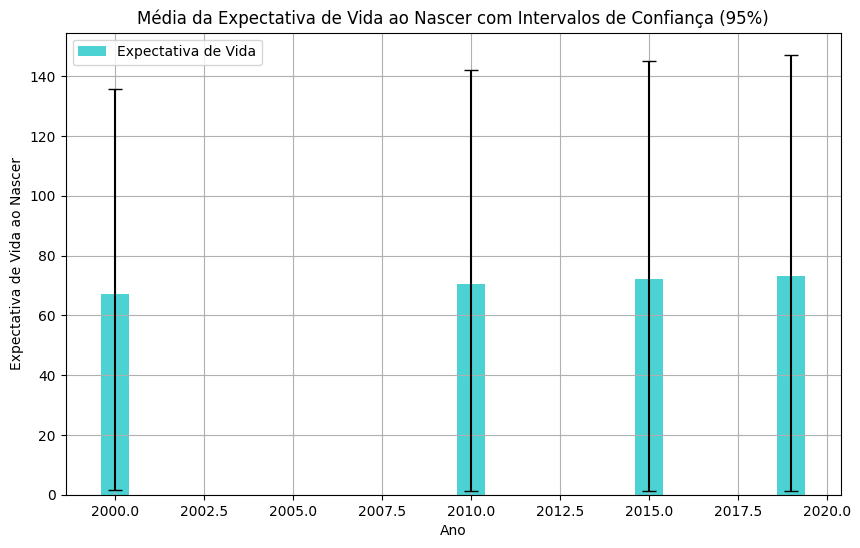

In [298]:
import matplotlib.pyplot as plt

# Anos e ICs
years = [2000, 2010, 2015, 2019]
lower_bounds = [confidence_intervals[year]['Lower Bound'] for year in years]
upper_bounds = [confidence_intervals[year]['Upper Bound'] for year in years]
mean_expectativa = [df_exp_nasc_e_tabaco[f'{year}_expectativa'].mean() for year in years]

# Filtrar anos com valores não zerados
non_zero_years = [year for year, mean in zip(years, mean_expectativa) if mean != 0]
non_zero_lower_bounds = [lower for lower, mean in zip(lower_bounds, mean_expectativa) if mean != 0]
non_zero_upper_bounds = [upper for upper, mean in zip(upper_bounds, mean_expectativa) if mean != 0]

# Configuração do gráfico de barras com barras de erro
plt.figure(figsize=(10, 6))
plt.bar(non_zero_years, [mean for mean in mean_expectativa if mean != 0], 
        yerr=[non_zero_lower_bounds, non_zero_upper_bounds], capsize=5, color='c', alpha=0.7, label='Expectativa de Vida')

# Configurações adicionais
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida ao Nascer')
plt.title('Média da Expectativa de Vida ao Nascer com Intervalos de Confiança (95%)')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


Text(0.5, 1.0, 'Correlação')

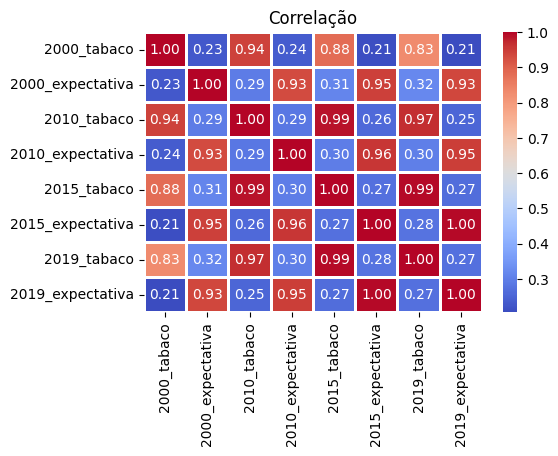

In [299]:
#correlação para todos os anos 

correlacao = df_exp_nasc_e_tabaco[['2000_tabaco', '2000_expectativa', '2010_tabaco', '2010_expectativa', '2015_tabaco', '2015_expectativa', '2019_tabaco', '2019_expectativa']].corr()

# Plotar as matrizes de correlação como gráficos de calor (heatmaps)
plt.figure(figsize=(12, 8))

plt.subplot(221)
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlação')


# Regressão Linear

In [300]:
#Normalizando os dados
from sklearn.preprocessing import MinMaxScaler

# Criar um objeto MinMaxScaler
scaler = MinMaxScaler()

# Normalizar os dados
df_exp_nasc_e_tabaco_scaled = scaler.fit_transform(df_exp_nasc_e_tabaco[['2000_tabaco', '2000_expectativa', '2010_tabaco', '2010_expectativa', '2015_tabaco', '2015_expectativa', '2019_tabaco', '2019_expectativa']])
df_exp_nasc_e_tabaco_scaled = pd.DataFrame(df_exp_nasc_e_tabaco_scaled, columns=['2000_tabaco', '2000_expectativa', '2010_tabaco', '2010_expectativa', '2015_tabaco', '2015_expectativa', '2019_tabaco', '2019_expectativa'])

# Visualizar os dados normalizados
df_exp_nasc_e_tabaco_scaled.head()


,2000_tabaco,2000_expectativa,2010_tabaco,2010_expectativa,2015_tabaco,2015_expectativa,2019_tabaco,2019_expectativa
0,0.249595,0.761382,0.334004,0.867121,0.378924,0.803060,0.419277,0.787228
1,0.160454,0.343064,0.116700,0.567899,0.098655,0.397497,0.086747,0.378395
2,0.427877,0.048473,0.400402,0.522568,0.392377,0.368846,0.390361,0.343181
3,0.372771,0.210498,0.313883,0.531323,0.286996,0.368567,0.272289,0.356610
4,0.278768,0.000000,0.235412,0.531518,0.217489,0.400000,0.207229,0.390630


Equação da reta: y = 0.2620032444224608 * x + 0.5805185046190943
R2: 0.06427091078211888


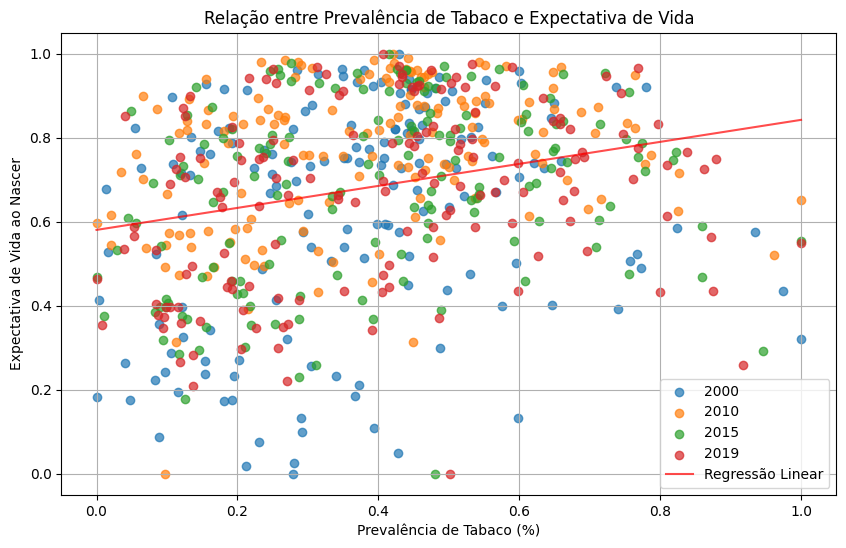

In [301]:
# Anos
years = [2000, 2010, 2015, 2019]

# Dados de treino
X_train = []
y_train = []

for year in years:
    X_train.append(df_exp_nasc_e_tabaco_scaled[f'{year}_tabaco'].values.reshape(-1, 1))
    y_train.append(df_exp_nasc_e_tabaco_scaled[f'{year}_expectativa'].values.reshape(-1, 1))

# Concatenar os dados
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Treinar o modelo de regressão linear
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

#imprimir a equação da reta
print(f'Equação da reta: y = {regression_model.coef_[0][0]} * x + {regression_model.intercept_[0]}')

# Calcular o coeficiente de determinação (R2)
r2 = regression_model.score(X_train, y_train)
print(f'R2: {r2}')

# Calcular o erro padrão residual
y_predicted = regression_model.predict(X_train)
residuals = y_train - y_predicted



# Plotar os dados
plt.figure(figsize=(10, 6))
for year in years:
    plt.scatter(df_exp_nasc_e_tabaco_scaled[f'{year}_tabaco'], df_exp_nasc_e_tabaco_scaled[f'{year}_expectativa'], alpha=0.7, label=str(year))

# Plotar a linha de regressão linear
x_range = np.linspace(min(X_train), max(X_train), 100).reshape(-1, 1)
plt.plot(x_range, regression_model.predict(x_range), color='r', alpha=0.7, label='Regressão Linear')

# Configurações adicionais
plt.xlabel('Prevalência de Tabaco (%)')
plt.ylabel('Expectativa de Vida ao Nascer')
plt.title('Relação entre Prevalência de Tabaco e Expectativa de Vida')
plt.legend()
plt.grid(True)

plt.show()


In [302]:
# Calcular ICs para os coeficientes e para r2

# Nível de confiança desejado (por exemplo, 95%)
conf_level = 0.95

# Tamanho da amostra
sample_size = len(X_train)

# Cálculo do erro padrão
std_error = np.sqrt(np.sum(residuals ** 2) / (sample_size - 2))

# Cálculo do valor crítico (z-score) com base no nível de confiança
z = norm.ppf(1 - (1 - conf_level) / 2)

# Cálculo do intervalo de confiança para os coeficientes
lower_bound_coef = regression_model.coef_[0][0] - z * std_error
upper_bound_coef = regression_model.coef_[0][0] + z * std_error

# Cálculo do intervalo de confiança para o intercepto
lower_bound_intercept = regression_model.intercept_[0] - z * std_error
upper_bound_intercept = regression_model.intercept_[0] + z * std_error

# Calculo do intervalo de confiança para o R2
lower_bound_r2 = r2 - z * std_error
upper_bound_r2 = r2 + z * std_error


# Imprimir os resultados
print(f'Intervalo de Confiança para o Coeficiente: [{lower_bound_coef}, {upper_bound_coef}]')
print(f'Intervalo de Confiança para o Intercepto: [{lower_bound_intercept}, {upper_bound_intercept}]')
print(f'Intervalo de Confiança para o R2: [{lower_bound_r2}, {upper_bound_r2}]')




Intervalo de Confiança para o Coeficiente: [-0.16082670466324261, 0.6848331935081642]
Intervalo de Confiança para o Intercepto: [0.15768855553339084, 1.0033484537047976]
Intervalo de Confiança para o R2: [-0.35855903830358454, 0.4871008598678223]


# Aspectos Economicos: Coeficiente de GINI e PIB

## Tratando os dados


In [303]:
df_expectativa_vida = pd.read_csv('./dataset/expectativa_vida.csv', sep=',')

# Selecionando somente as colunas importantes para a análise dos dados
df_expectativa_vida  = df_expectativa_vida[['Indicator','ParentLocation','Country', 'Period', 'Dim1', 'Value']]

# Renomeando a coluna período para ano
df_expectativa_vida.rename(columns={'Period': 'Year'}, inplace=True)
df_expectativa_vida.rename(columns={'Value': 'Life expectancy'}, inplace=True)

In [304]:
# Separando os dados com base no indicador - Expectativa de vida ao nascer
df_expectativa_ao_nascer = df_expectativa_vida[df_expectativa_vida['Indicator'] == 'Life expectancy at birth (years)']

# Selecionando somente os dados para ambos os sexos
df_expectativa_ao_nascer= df_expectativa_ao_nascer[df_expectativa_ao_nascer['Dim1'] == 'Both sexes']

df_expectativa_ao_nascer.head()

,Indicator,ParentLocation,Country,Year,Dim1,Life expectancy
2,Life expectancy at birth (years),Africa,Lesotho,2019,Both sexes,50.75
3,Life expectancy at birth (years),Africa,Central African Republic,2019,Both sexes,53.10
10,Life expectancy at birth (years),Eastern Mediterranean,Somalia,2019,Both sexes,56.47
13,Life expectancy at birth (years),Africa,Eswatini,2019,Both sexes,57.73
15,Life expectancy at birth (years),Africa,Mozambique,2019,Both sexes,58.14


In [305]:
# Separando os dados com base no indicador - Expectativa de vida aos 60 anos
df_expectativa_aos_60 = df_expectativa_vida[df_expectativa_vida['Indicator'] == 'Life expectancy at age 60 (years)']

# Selecionando somente os dados para ambos os sexos
df_expectativa_aos_60 = df_expectativa_aos_60[df_expectativa_aos_60['Dim1'] == 'Both sexes']

df_expectativa_aos_60.head()

,Indicator,ParentLocation,Country,Year,Dim1,Life expectancy
553,Life expectancy at age 60 (years),Africa,Central African Republic,2019,Both sexes,13.17
556,Life expectancy at age 60 (years),Africa,Lesotho,2019,Both sexes,13.43
558,Life expectancy at age 60 (years),Western Pacific,Kiribati,2019,Both sexes,13.69
564,Life expectancy at age 60 (years),Eastern Mediterranean,Somalia,2019,Both sexes,14.54
568,Life expectancy at age 60 (years),Western Pacific,Micronesia (Federated States of),2019,Both sexes,14.70


In [306]:
df_expectativa_ao_nascer['Year'] = df_expectativa_ao_nascer['Year'].astype(str)

### Coeficiente de Gini

In [307]:
df_expectativa_ao_nascer['Year'] = df_expectativa_ao_nascer['Year'].astype(str)

In [308]:
# Carregar o DataFrame a partir do arquivo CSV
df_gini = pd.read_csv('./dataset/economic-inequality-gini-index.csv')

df_gini

,Entity,Code,Year,Gini coefficient
0,Albania,ALB,1996,0.270103
1,Albania,ALB,2002,0.317390
2,Albania,ALB,2005,0.305957
3,Albania,ALB,2008,0.299847
4,Albania,ALB,2012,0.289605
...,...,...,...,...
2120,Zambia,ZMB,2010,0.556215
2121,Zambia,ZMB,2015,0.571361
2122,Zimbabwe,ZWE,2011,0.431536
2123,Zimbabwe,ZWE,2017,0.443371


In [309]:
# Renomeando coluna Entity para Country
df_gini.rename(columns={'Entity': 'Country'}, inplace=True)

df_gini = df_gini[["Country", "Year", "Gini coefficient"]]



In [310]:
df_gini = df_gini.copy()
df_gini['Year'] = df_gini['Year'].astype(str) 

In [311]:
# Juntando tabela de expectativa de vida com Coeficiente de Gini por meio do ano e país
df_gini_merged = pd.merge(df_expectativa_ao_nascer, df_gini, on=['Year', 'Country'], how="inner")

df_gini_merged

,Indicator,ParentLocation,Country,Year,Dim1,Life expectancy,Gini coefficient
0,Life expectancy at birth (years),Western Pacific,Kiribati,2019,Both sexes,59.42,0.278327
1,Life expectancy at birth (years),Africa,Zimbabwe,2019,Both sexes,60.68,0.502564
2,Life expectancy at birth (years),Western Pacific,Vanuatu,2019,Both sexes,65.31,0.323176
3,Life expectancy at birth (years),Africa,Malawi,2019,Both sexes,65.62,0.385432
4,Life expectancy at birth (years),Africa,Uganda,2019,Both sexes,66.69,0.427055
...,...,...,...,...,...,...,...
244,Life expectancy at birth (years),Europe,Spain,2000,Both sexes,79.08,0.342510
245,Life expectancy at birth (years),Americas,Canada,2000,Both sexes,79.10,0.333439
246,Life expectancy at birth (years),Europe,Italy,2000,Both sexes,79.36,0.352528
247,Life expectancy at birth (years),Europe,Sweden,2000,Both sexes,79.57,0.272364


In [312]:
mean_gini_by_country = df_gini.groupby('Country')['Gini coefficient'].mean().reset_index()

mean_gini_by_country.rename(columns={'Gini coefficient': 'Mean Gini Coefficient'}, inplace=True)

mean_gini_by_country

,Country,Mean Gini Coefficient
0,Albania,0.312141
1,Algeria,0.343802
2,Angola,0.486482
3,Argentina - urban,0.458159
4,Armenia,0.324759
...,...,...
178,Venezuela,0.480091
179,Vietnam,0.360825
180,Yemen,0.354791
181,Zambia,0.527016


### PIB - Novo

In [313]:
df_pib = pd.read_csv('./dataset/gdp.csv')

df_pib = df_pib[["Country", "2000", "2010", "2015", "2019"]]

df_pib

,Country,2000,2010,2015,2019
0,"Afghanistan, Rep. of.",0,15.406,0,0
1,Albania,3.695,11.797,11.591,15.553
2,Algeria,54.749,154.843,175.077,210.906
3,Angola,9.135,87.718,102.011,119.403
4,Antigua and Barbuda,0.678,1.196,1.285,1.536
...,...,...,...,...,...
175,Venezuela,117.153,379.16,131.855,170.41
176,Vietnam,31.196,102.906,198.805,265.987
177,"Yemen, Republic of",9.561,31.98,0,0
178,Zambia,3.238,15.792,24.466,32.957


In [314]:
df_pib_melted = df_pib.melt(id_vars=["Country"], var_name="Year", value_name="PIB")

df_pib_melted

,Country,Year,PIB
0,"Afghanistan, Rep. of.",2000,0
1,Albania,2000,3.695
2,Algeria,2000,54.749
3,Angola,2000,9.135
4,Antigua and Barbuda,2000,0.678
...,...,...,...
715,Venezuela,2019,170.41
716,Vietnam,2019,265.987
717,"Yemen, Republic of",2019,0
718,Zambia,2019,32.957


In [315]:
# Convertendo coluna de Year para string
df_pib_melted['Year'] = df_pib_melted['Year'].astype(str)

# Preenchedo "," dos valores de PIB's para evitar que ocorra erro na hora da conversão para numérico 
df_pib_melted['PIB'] = df_pib_melted['PIB'].str.replace(',', '')
df_pib_melted['PIB'] = pd.to_numeric(df_pib_melted['PIB'], errors='coerce')

In [316]:
# Fazendo o merge dos DadaFrames
df_pib_merged = pd.merge(df_expectativa_ao_nascer, df_pib_melted, on=['Country', 'Year'], how='inner')

df_pib_merged

,Indicator,ParentLocation,Country,Year,Dim1,Life expectancy,PIB
0,Life expectancy at birth (years),Africa,Lesotho,2019,Both sexes,50.75,2.538
1,Life expectancy at birth (years),Africa,Central African Republic,2019,Both sexes,53.10,2.637
2,Life expectancy at birth (years),Africa,Mozambique,2019,Both sexes,58.14,26.495
3,Life expectancy at birth (years),Western Pacific,Kiribati,2019,Both sexes,59.42,0.175
4,Life expectancy at birth (years),Africa,Chad,2019,Both sexes,59.63,17.440
...,...,...,...,...,...,...,...
587,Life expectancy at birth (years),Europe,Sweden,2000,Both sexes,79.57,242.792
588,Life expectancy at birth (years),Western Pacific,Australia,2000,Both sexes,79.69,390.017
589,Life expectancy at birth (years),Europe,Iceland,2000,Both sexes,79.70,8.678
590,Life expectancy at birth (years),Europe,Switzerland,2000,Both sexes,79.72,246.322


Calculando a média dos pibs dos países

In [317]:
mean_pib_by_country = df_pib_melted.groupby('Country')['PIB'].mean().reset_index()

mean_pib_by_country.rename(columns={'PIB': 'Mean PIB'}, inplace=True)

mean_pib_by_country

,Country,Mean PIB
0,"Afghanistan, Rep. of.",3.85150
1,Albania,10.65900
2,Algeria,148.89375
3,Angola,79.56675
4,Antigua and Barbuda,1.17375
...,...,...
175,Venezuela,199.64450
176,Vietnam,149.72350
177,"Yemen, Republic of",10.38525
178,Zambia,19.11325


### Visualização Inicial dos dados

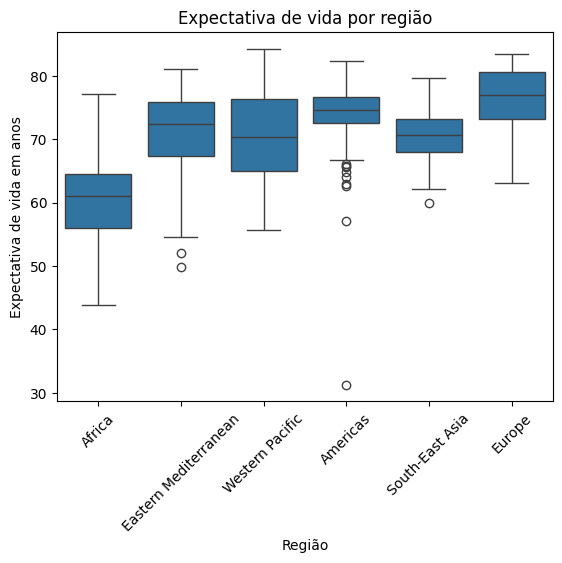

In [318]:
sns.boxplot(x='ParentLocation', y='Life expectancy', data=df_expectativa_ao_nascer)
plt.title('Expectativa de vida por região')
plt.xlabel('Região')
plt.ylabel('Expectativa de vida em anos')
plt.xticks(rotation=45)  # This helps if the region names are long and overlap
plt.show()

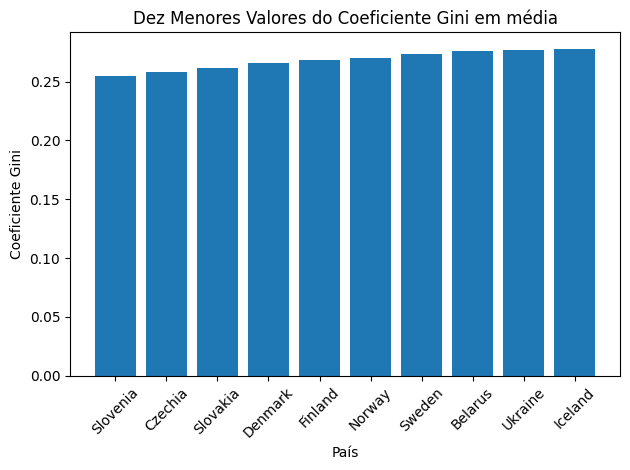

In [319]:
# df_gini_2019 = df_gini.query("Year == '2019'")

df_gini_ordenado = mean_gini_by_country.sort_values(by='Mean Gini Coefficient').reset_index().drop(columns="index", axis=1)

cinco_menores_valores = df_gini_ordenado.head(10)

plt.bar(cinco_menores_valores['Country'], cinco_menores_valores['Mean Gini Coefficient'])
plt.xlabel('País')
plt.ylabel('Coeficiente Gini')
plt.title('Dez Menores Valores do Coeficiente Gini em média')

# Rotacionar os rótulos do eixo x para facilitar a leitura (opcional)
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

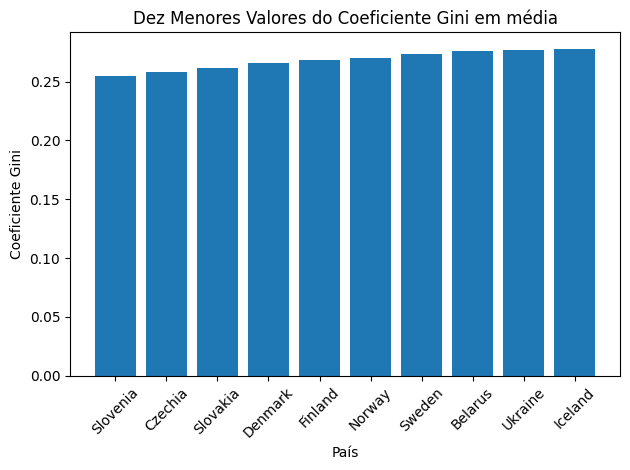

In [320]:
# df_gini_2019 = df_gini.query("Year == '2019'")

df_gini_ordenado = mean_gini_by_country.sort_values(by='Mean Gini Coefficient').reset_index().drop(columns="index", axis=1)

cinco_menores_valores = df_gini_ordenado.head(10)

plt.bar(cinco_menores_valores['Country'], cinco_menores_valores['Mean Gini Coefficient'])
plt.xlabel('País')
plt.ylabel('Coeficiente Gini')
plt.title('Dez Menores Valores do Coeficiente Gini em média')

# Rotacionar os rótulos do eixo x para facilitar a leitura (opcional)
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [321]:
df_gini_merged.describe()

,Life expectancy,Gini coefficient
count,249.000000,249.000000
mean,74.382369,0.364306
std,6.945328,0.086261
min,47.050000,0.232323
25%,71.150000,0.299505
50%,75.870000,0.339957
75%,79.720000,0.410664
max,83.220000,0.633832


In [322]:
df_pib_merged.describe()

,Life expectancy,PIB
count,592.000000,592.000000
mean,70.454797,272.994042
std,8.804686,1000.181560
min,31.280000,0.000000
25%,64.572500,5.873250
50%,72.275000,24.355500
75%,76.727500,160.464750
max,84.260000,15620.710000


## Correlação entre os dados

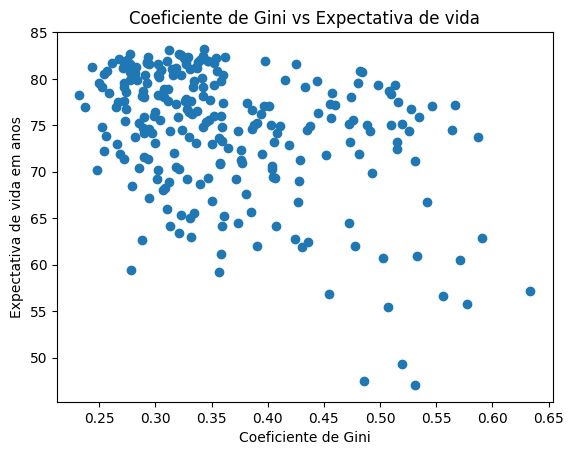

In [323]:
# Assuming df_merged is your merged dataframe
plt.scatter(df_gini_merged['Gini coefficient'], df_gini_merged['Life expectancy'])
plt.title('Coeficiente de Gini vs Expectativa de vida')
plt.xlabel('Coeficiente de Gini')
plt.ylabel('Expectativa de vida em anos')
plt.show()

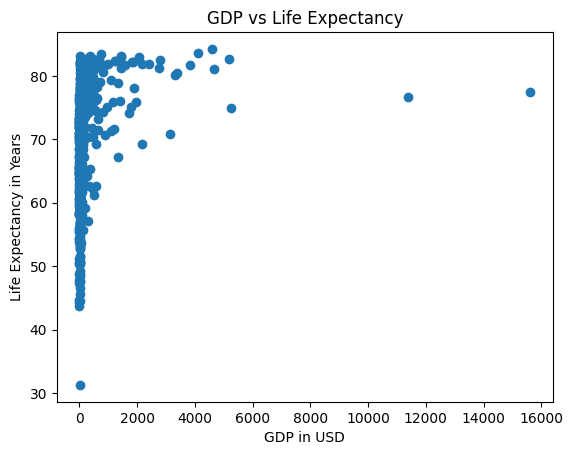

In [324]:
# Assuming df_merged is your merged dataframe
plt.scatter(df_pib_merged['PIB'], df_pib_merged['Life expectancy'])
plt.title('GDP vs Life Expectancy')
plt.xlabel('GDP in USD')
plt.ylabel('Life Expectancy in Years')
plt.show()

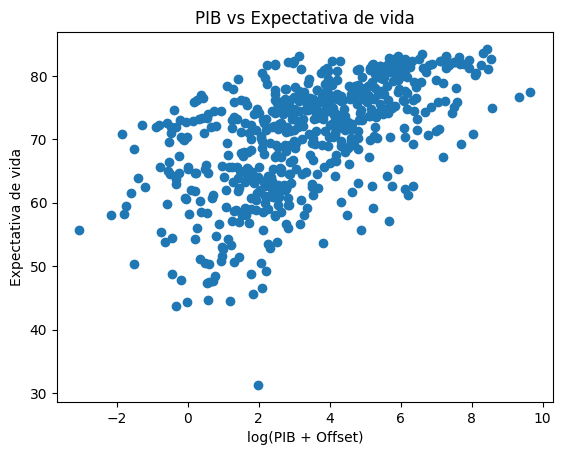

In [325]:
df_pib_merged_without_zero = df_pib_merged[df_pib_merged['PIB'] > 0]

plt.scatter(np.log(df_pib_merged_without_zero['PIB']), df_pib_merged_without_zero['Life expectancy'])
plt.title('PIB vs Expectativa de vida')
plt.xlabel('log(PIB + Offset)')
plt.ylabel('Expectativa de vida')
plt.show()

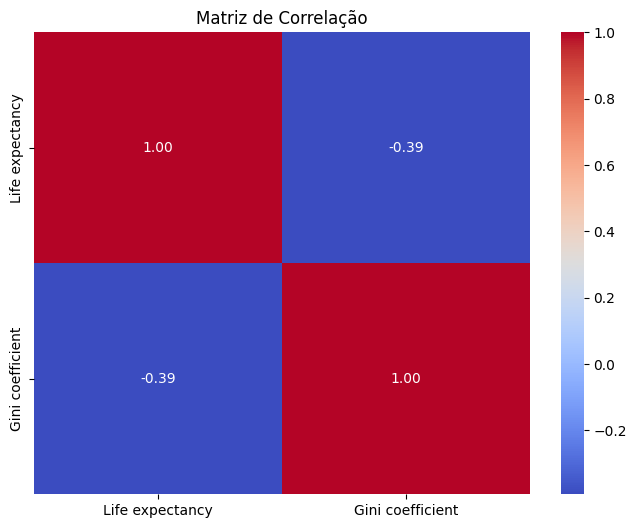

In [326]:
gini_matriz = df_gini_merged

matriz_correlacao = gini_matriz.corr(numeric_only=True)

plt.figure(figsize=(8, 6))

# Plotar a matriz de correlação usando heatmap
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")

# Adicionar título ao gráfico
plt.title('Matriz de Correlação')

# Exibir o gráfico
plt.show()

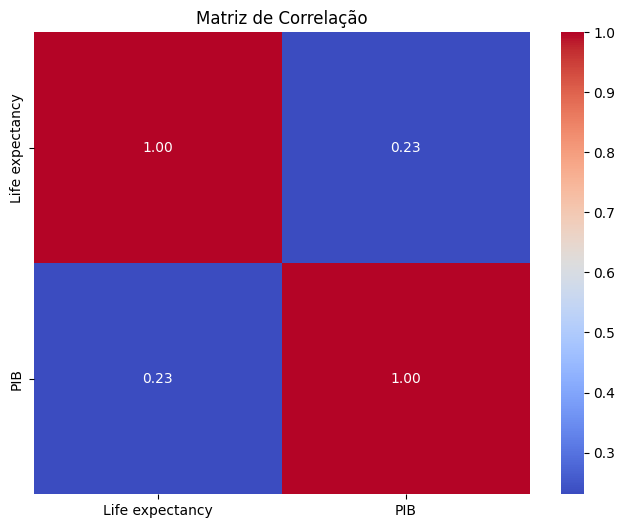

In [327]:
colunas_strings = df_pib_merged.select_dtypes(include=['object'])

nomes_colunas_strings = colunas_strings.columns.tolist()

df_matriz = df_pib_merged.drop(columns=nomes_colunas_strings)

df_matriz = df_pib_merged.corr(numeric_only=True)

plt.figure(figsize=(8, 6))

sns.heatmap(df_matriz, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Matriz de Correlação')

plt.show()

# Realizar teste de Hipoteses

Para realizar o teste de hipótese, devemos definir a hipótese nula e a hipótese alternativa, como mostrado abaixo:

Hipótese nula (H0): Não há relação significativa entre a expectativa de vida e o PIB ou o coeficiente de Gini.

Hipótese alternativa (H1): Existe uma relação significativa entre a expectativa de vida e o PIB ou o coeficiente de Gini.

Expectativa de Vida Mediana: A linha dentro de cada caixa indica a expectativa de vida mediana para cada região. A Europa parece ter a expectativa de vida mediana mais alta, enquanto a África tem a mais baixa. Isso sugere que, em média, as pessoas na Europa vivem mais do que aquelas na África.

Intervalo Interquartil (IQR): O comprimento da caixa representa o IQR, que é o intervalo entre o primeiro quartil (percentil 25) e o terceiro quartil (percentil 75). Uma caixa mais longa indica uma maior disparidade dentro dos dados de expectativa de vida dessa região. O Pacífico Ocidental e a Europa mostram um IQR relativamente amplo, indicando mais variação na expectativa de vida dentro dessas regiões.

Outliers (Valores Atípicos): Os pontos fora dos 'bigodes' das caixas representam outliers. A África e as Américas têm outliers na extremidade inferior, indicando que há países nessas regiões com expectativas de vida significativamente mais baixas do que a média.

Dispersão e Distribuição: Os 'bigodes' que se estendem das caixas mostram o alcance dos dados excluindo outliers. As Américas e a Europa têm bigodes superiores longos, sugerindo que há países com expectativas de vida que se estendem bem além do percentil 75. Por outro lado, o bigode inferior da África indica que a região tem países com expectativas de vida estendendo-se abaixo do percentil 25.

Simetria: Se uma caixa é simétrica, isso sugere que os dados estão distribuídos de maneira uniforme ao redor da mediana. A caixa para o Mediterrâneo Oriental é bastante simétrica, sugerindo uma distribuição equilibrada ao redor da expectativa de vida mediana.

Comparação Entre Regiões: Há uma clara disparidade na expectativa de vida entre diferentes regiões. Por exemplo, a expectativa de vida na África é geralmente mais baixa do que em outras regiões, enquanto a Europa tem geralmente uma expectativa de vida mais alta.

Fatores de Saúde Pública e Socioeconômicos: As diferenças na expectativa de vida entre as regiões podem refletir vários fatores, como condições econômicas, acesso à saúde, estilo de vida e políticas de saúde pública.

Implicações Políticas: Tal visualização poderia ser usada por formuladores de políticas para identificar regiões que precisam de intervenções de saúde e para fazer benchmarking com regiões de maior expectativa de vida.

É importante notar que, embora os boxplots sejam úteis para visualizar a distribuição dos dados, eles não fornecem informações sobre as causas subjacentes das diferenças. Análises mais detalhadas seriam necessárias para entender os fatores que contribuem para a variação na expectativa de vida entre essas regiões.


# Regressão Linear

## Coeficiente de Gini


In [328]:
X = df_gini_merged[['Gini coefficient']] # Variáveis independentes
y = df_gini_merged['Life expectancy'] # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Adicionando uma constante ao modelo
X = sm.add_constant(X_scaled)

# Criando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibindo os resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     44.94
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           1.37e-10
Time:                        14:59:27   Log-Likelihood:                -814.58
No. Observations:                 249   AIC:                             1633.
Df Residuals:                     247   BIC:                             1640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.3824      0.406    183.357      0.0

In [329]:
X = df_gini_merged[['Gini coefficient']].values.reshape(-1,1) # Variáveis independentes
y = df_gini_merged['Life expectancy'].values.reshape(-1,1) # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Criando o modelo de regressão linear
modelo = LinearRegression()

# Ajustando o modelo aos dados de treino
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f'Coefficient: {modelo.coef_}')
print(f'Intercept: {modelo.intercept_}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')

Coefficient: [[-2.26016631]]
Intercept: [74.72059239]
Mean squared error: 63.98
R2: 0.15


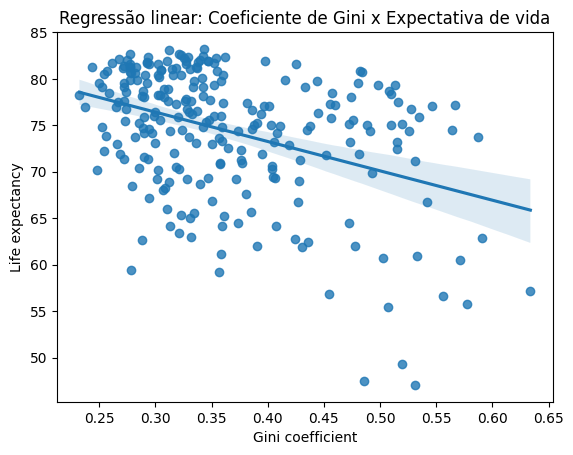

In [330]:
sns.regplot(x='Gini coefficient', y='Life expectancy', data=df_gini_merged)
plt.title('Regressão linear: Coeficiente de Gini x Expectativa de vida')
plt.show()

## PIB

In [331]:
X = df_pib_merged[['PIB']] # Variáveis independentes
y = df_pib_merged['Life expectancy'] # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Adicionando uma constante ao modelo
X = sm.add_constant(X_scaled)

# Criando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibindo os resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     33.12
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           1.39e-08
Time:                        14:59:28   Log-Likelihood:                -2111.1
No. Observations:                 592   AIC:                             4226.
Df Residuals:                     590   BIC:                             4235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.4548      0.352    199.917      0.0

In [332]:
X = df_pib_merged_without_zero[['PIB']].values.reshape(-1,1) # Variáveis independentes
y = df_pib_merged_without_zero['Life expectancy'].values.reshape(-1,1) # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Criando o modelo de regressão linear
modelo = LinearRegression()

# Ajustando o modelo aos dados de treino
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f'Coefficient: {modelo.coef_}')
print(f'Intercept: {modelo.intercept_}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')

Coefficient: [[4.01756406]]
Intercept: [70.69755834]
Mean squared error: 95.92
R2: -0.36


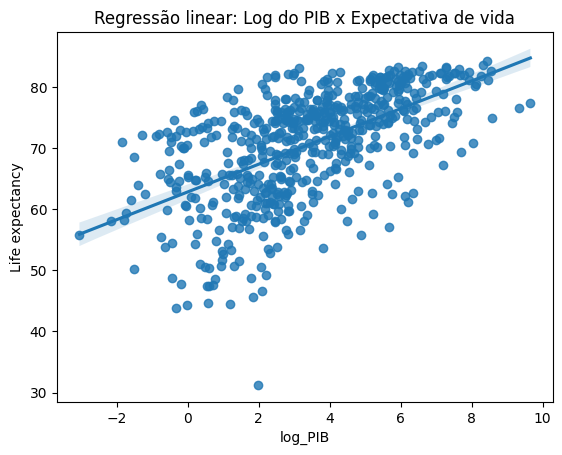

In [333]:
df_pib_merged_without_zero = df_pib_merged[df_pib_merged['PIB'] > 0]

df_pib_merged['log_PIB'] = np.log(df_pib_merged_without_zero['PIB'])

# Plota o gráfico de regressão com o logaritmo do PIB
sns.regplot(x='log_PIB', y='Life expectancy', data=df_pib_merged)
plt.title('Regressão linear: Log do PIB x Expectativa de vida')
plt.show()

# Aspectos Ambientais: Saneamento Básico

## Manipulação dos dados


In [334]:
df_expectativa_vida = pd.read_csv('./dataset/expectativa_vida.csv', sep=',')
#modificar para o arquivo local

df_expectativa_vida  = df_expectativa_vida[['Indicator','ParentLocation','Country', 'Period', 'Dim1', 'Value']]

# Pivotando o dataframe para transformar a coluna 'Period' em colunas separadas para os anos desejados
df_expectativa_vida = df_expectativa_vida.pivot_table(index=['Indicator', 'ParentLocation', 'Country', 'Dim1'], columns='Period', values='Value').reset_index()

# Selecionando apenas as colunas desejadas
df_expectativa_vida = df_expectativa_vida[['Indicator', 'ParentLocation', 'Country', 'Dim1', 2000, 2010, 2015, 2019]]
df_expectativa_vida.head()

Period,Indicator,ParentLocation,Country,Dim1,2000,2010,2015,2019
0,Life expectancy at age 60 (years),Africa,Algeria,Both sexes,19.81,21.37,21.81,22.04
1,Life expectancy at age 60 (years),Africa,Algeria,Female,20.25,21.85,22.33,22.62
2,Life expectancy at age 60 (years),Africa,Algeria,Male,19.36,20.89,21.33,21.53
3,Life expectancy at age 60 (years),Africa,Angola,Both sexes,14.42,15.97,16.71,16.98
4,Life expectancy at age 60 (years),Africa,Angola,Female,16.01,17.54,18.42,18.55


In [335]:
df_expectativa_ao_nascer = df_expectativa_vida[df_expectativa_vida['Indicator'] == 'Life expectancy at birth (years)']
df_expectativa_ao_nascer= df_expectativa_ao_nascer[df_expectativa_ao_nascer['Dim1'] == 'Both sexes']

df_expectativa_ao_nascer.head()


Period,Indicator,ParentLocation,Country,Dim1,2000,2010,2015,2019
549,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13
552,Life expectancy at birth (years),Africa,Angola,Both sexes,49.30,58.07,61.72,63.06
555,Life expectancy at birth (years),Africa,Benin,Both sexes,56.59,60.47,61.96,63.43
558,Life expectancy at birth (years),Africa,Botswana,Both sexes,45.59,58.14,60.93,62.25
561,Life expectancy at birth (years),Africa,Burkina Faso,Both sexes,51.64,58.59,60.92,62.70


In [336]:
df_expectativa_ao_nascer = df_expectativa_ao_nascer.rename(columns={2000: 'LifeExp_2000', 2010: 'LifeExp_2010', 2015: 'LifeExp_2015', 2019: 'LifeExp_2019'})
df_hdi = df_hdi.rename(columns={'2000': 'HDI_2000', '2010': 'HDI_2010', '2015': 'HDI_2015', '2019': 'HDI_2019'})

In [337]:
merged_df_12 = pd.merge(df_expectativa_ao_nascer, df_hdi, on='Country', how='inner')

merged_df_12.head(300)

,Indicator,ParentLocation,Country,Dim1,LifeExp_2000,LifeExp_2010,LifeExp_2015,LifeExp_2019,HDI Rank,HDI_2000,HDI_2010,HDI_2015,HDI_2019
0,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637000,0.721,0.740,0.748
1,Life expectancy at birth (years),Africa,Angola,Both sexes,49.30,58.07,61.72,63.06,148.0,0.400000,0.517,0.572,0.581
2,Life expectancy at birth (years),Africa,Benin,Both sexes,56.59,60.47,61.96,63.43,158.0,0.416000,0.494,0.532,0.545
3,Life expectancy at birth (years),Africa,Botswana,Both sexes,45.59,58.14,60.93,62.25,100.0,0.581000,0.663,0.717,0.735
4,Life expectancy at birth (years),Africa,Burkina Faso,Both sexes,51.64,58.59,60.92,62.70,182.0,0.293000,0.384,0.422,0.452
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,Life expectancy at birth (years),Western Pacific,Singapore,Both sexes,78.44,81.70,82.81,83.22,11.0,0.821000,0.909,0.931,0.938
167,Life expectancy at birth (years),Western Pacific,Solomon Islands,Both sexes,62.51,63.69,64.74,65.25,151.0,0.475000,0.537,0.563,0.567
168,Life expectancy at birth (years),Western Pacific,Tonga,Both sexes,70.92,72.22,72.33,72.57,104.0,0.675000,0.699,0.720,0.725
169,Life expectancy at birth (years),Western Pacific,Vanuatu,Both sexes,63.90,64.52,64.64,65.31,140.0,0.629725,0.590,0.598,0.609


### Proporção da população que possui saneamento básico tratado

In [338]:
df_saneamento_uso = pd.read_csv('./dataset/share-using-safely-managed-sanitation.csv', sep=',')

#df_sem_saneamento  = df_saneamento[['Entity','Year','san_sm_number_without']]
df_saneamento_uso = df_saneamento_uso.rename(columns={'6.2.1 - Proportion of population using safely managed sanitation services, by urban/rural (%) - SH_SAN_SAFE - All areas': 'Proportion of Population (by years)'})
df_saneamento_uso_novo = df_saneamento_uso.copy()
print(df_saneamento_uso)

        Entity Code  Year  Proportion of Population (by years)
0      Algeria  DZA  2000                                58.85
1      Algeria  DZA  2001                                59.19
2      Algeria  DZA  2002                                59.53
3      Algeria  DZA  2003                                59.86
4      Algeria  DZA  2004                                60.18
...        ...  ...   ...                                  ...
3441  Zimbabwe  ZWE  2018                                33.54
3442  Zimbabwe  ZWE  2019                                32.96
3443  Zimbabwe  ZWE  2020                                32.38
3444  Zimbabwe  ZWE  2021                                31.80
3445  Zimbabwe  ZWE  2022                                31.81

[3446 rows x 4 columns]


In [339]:
# Converter a coluna 'Year' em string
df_saneamento_uso_novo['Year'] = df_saneamento_uso_novo['Year'].astype(str)

# Exibir o DataFrame com a coluna 'Year' como string
print(df_saneamento_uso_novo)

df_saneamento_uso_novo.describe()




        Entity Code  Year  Proportion of Population (by years)
0      Algeria  DZA  2000                                58.85
1      Algeria  DZA  2001                                59.19
2      Algeria  DZA  2002                                59.53
3      Algeria  DZA  2003                                59.86
4      Algeria  DZA  2004                                60.18
...        ...  ...   ...                                  ...
3441  Zimbabwe  ZWE  2018                                33.54
3442  Zimbabwe  ZWE  2019                                32.96
3443  Zimbabwe  ZWE  2020                                32.38
3444  Zimbabwe  ZWE  2021                                31.80
3445  Zimbabwe  ZWE  2022                                31.81

[3446 rows x 4 columns]


,Proportion of Population (by years)
count,3446.000000
mean,54.315987
std,30.300156
min,0.000000
25%,26.480000
50%,51.800000
75%,83.082500
max,100.000000


In [340]:
df_saneamento_2000_2015 = df_saneamento_uso[(df_saneamento_uso['Year'] >= 2000) & (df_saneamento_uso['Year'] <= 2015)]
# Calcular a média do uso de saneamento básico por país
media_uso_saneamento_por_pais = df_saneamento_2000_2015.groupby('Entity')['Proportion of Population (by years)'].mean().reset_index()

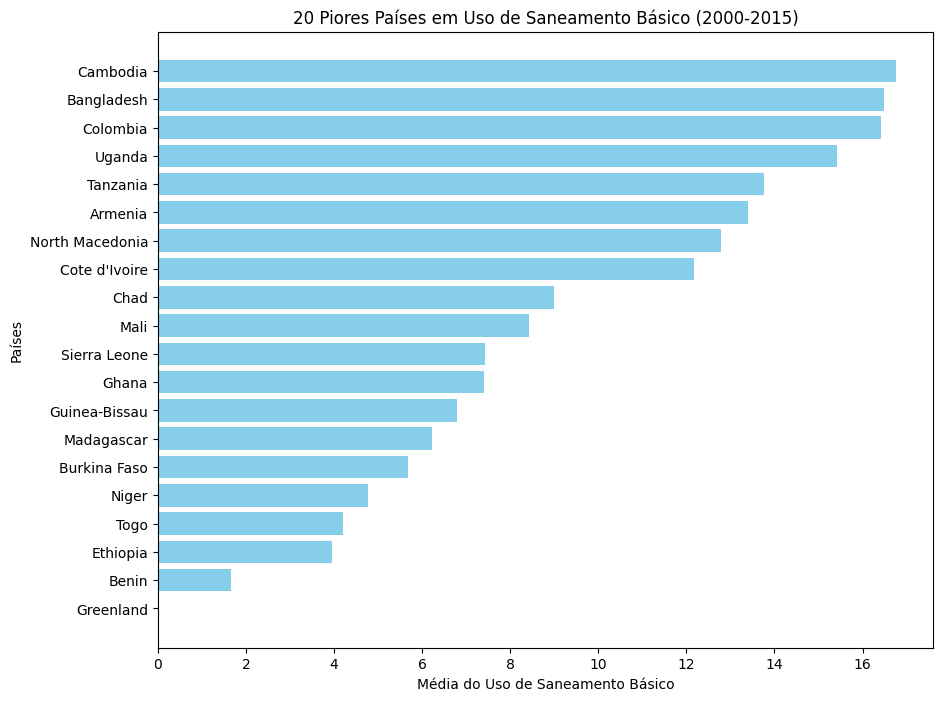

In [341]:
# Ordenar os países pela média em ordem ascendente e pegar os 20 piores
piores_paises = media_uso_saneamento_por_pais.sort_values(by='Proportion of Population (by years)', ascending=False).tail(20)

# Criar o gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(piores_paises['Entity'], piores_paises['Proportion of Population (by years)'], color='skyblue')
plt.xlabel('Média do Uso de Saneamento Básico')
plt.ylabel('Países')
plt.title('20 Piores Países em Uso de Saneamento Básico (2000-2015)')
plt.gca().invert_yaxis()
plt.show()


In [342]:
df_saneamento_2000_2015 = df_saneamento_uso[(df_saneamento_uso['Year'] >= 2000) & (df_saneamento_uso['Year'] <= 2015)]

# Calcular a média do uso de saneamento básico por ano
media_uso_saneamento_por_ano = df_saneamento_2000_2015.groupby('Year')['Proportion of Population (by years)'].mean().reset_index()

# Exibir a média por ano
print(media_uso_saneamento_por_ano)


    Year  Proportion of Population (by years)
0   2000                            49.551042
1   2001                            49.820000
2   2002                            50.150270
3   2003                            50.526554
4   2004                            50.655772
5   2005                            51.126711
6   2006                            51.435267
7   2007                            51.946400
8   2008                            52.470600
9   2009                            53.259205
10  2010                            53.825099
11  2011                            54.398411
12  2012                            54.974040
13  2013                            55.558940
14  2014                            55.796382
15  2015                            56.406316


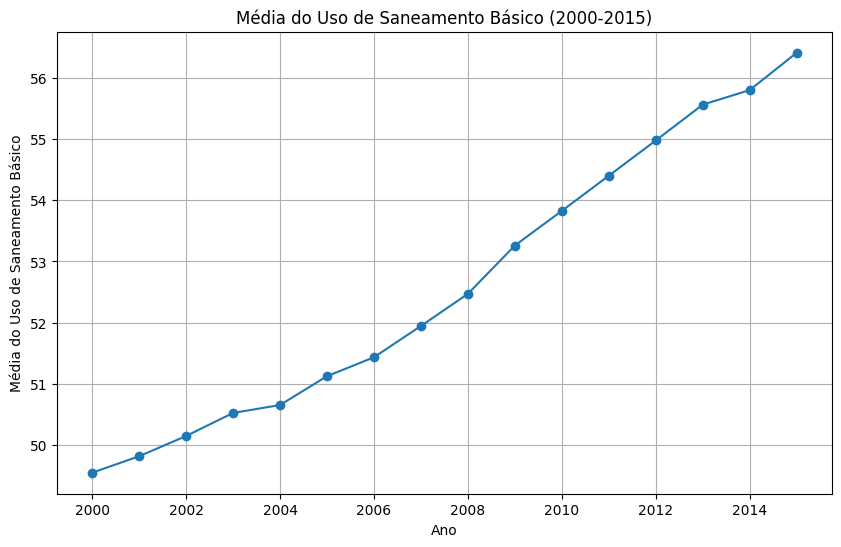

In [343]:
# Calcular a média do uso de saneamento básico por ano
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(media_uso_saneamento_por_ano['Year'], media_uso_saneamento_por_ano['Proportion of Population (by years)'], marker='o')
plt.xlabel('Ano')
plt.ylabel('Média do Uso de Saneamento Básico')
plt.title('Média do Uso de Saneamento Básico (2000-2015)')
plt.grid(True)
plt.show()


### A partir disso, entrar na problemática: Mortes por não uso do saneamento básico 

In [344]:
# Carregar o conjunto de dados de mortes por falta de saneamento
df_mortes_saneamento = pd.read_csv('./dataset/share-deaths-unsafe-sanitation.csv', sep=',')

# Renomear a coluna conforme especificado
df_mortes_saneamento = df_mortes_saneamento.rename(columns={'Share of total deaths that are from all causes attributed to unsafe sanitation, in both sexes aged age-standardized': 'Death'})

# Filtrar apenas os anos 2000, 2010, 2015 e 2019
anos_desejados = [2000, 2010, 2015, 2019]
df_mortes_saneamento_filtrado = df_mortes_saneamento[df_mortes_saneamento['Year'].isin(anos_desejados)].rename(columns={'Entity': 'Country'})

#df_mortes_saneamento_filtrado = df_mortes_saneamento.rename


# Exibir as primeiras linhas do DataFrame filtrado
df_mortes_saneamento_filtrado.head()


,Country,Code,Year,Death
10,Afghanistan,AFG,2000,1.118619
20,Afghanistan,AFG,2010,0.630359
25,Afghanistan,AFG,2015,0.453152
29,Afghanistan,AFG,2019,0.321068
40,African Region (WHO),NaN,2000,5.302774


## Realizando merge entre as tabelas:

In [345]:
#merged_df_12 = merged_df_12.drop(columns=['Death_x', 'Death_y'])
merged_df_12 = pd.merge(merged_df_12, df_mortes_saneamento_filtrado, on='Country', how='inner')


# Renomear colunas e filtrar os dados conforme especificado
df_mortes_saneamento_filtrado = df_mortes_saneamento_filtrado.rename(columns={'Entity': 'Country'})
df_mortes_saneamento_filtrado1 = df_mortes_saneamento_filtrado.rename(columns={'Entity': 'Country'})

# Executar o merge
# Note que merged_df_12 já é um merge entre df_expectativa_ao_nascer e df_hdi

merged_df_12.head()



,Indicator,ParentLocation,Country,Dim1,LifeExp_2000,LifeExp_2010,LifeExp_2015,LifeExp_2019,HDI Rank,HDI_2000,HDI_2010,HDI_2015,HDI_2019,Code,Year,Death
0,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637,0.721,0.740,0.748,DZA,2000,0.160559
1,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637,0.721,0.740,0.748,DZA,2010,0.067445
2,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637,0.721,0.740,0.748,DZA,2015,0.050067
3,Life expectancy at birth (years),Africa,Algeria,Both sexes,72.21,75.85,76.54,77.13,91.0,0.637,0.721,0.740,0.748,DZA,2019,0.037760
4,Life expectancy at birth (years),Africa,Angola,Both sexes,49.30,58.07,61.72,63.06,148.0,0.400,0.517,0.572,0.581,AGO,2000,7.573959


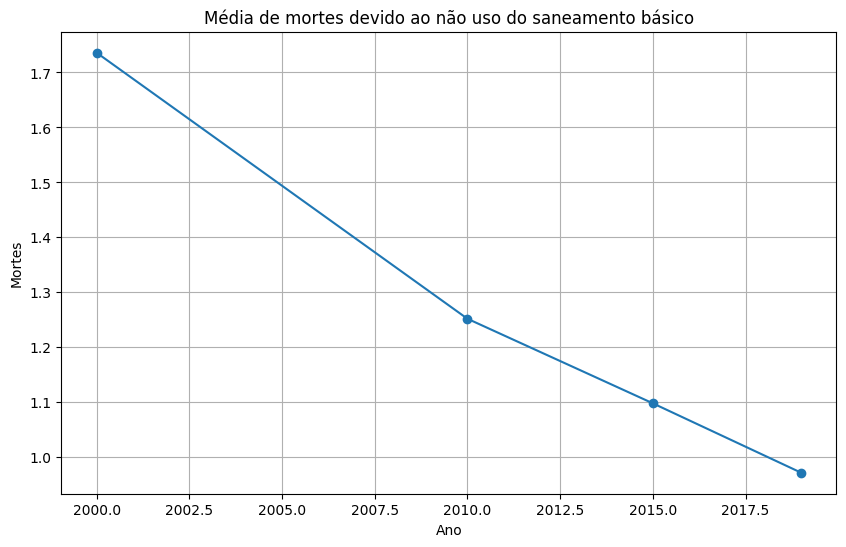

In [346]:
media_mortes = df_mortes_saneamento_filtrado.groupby('Year')['Death'].mean().reset_index()


# Criar um gráfico de linha mostrando o crescimento
plt.figure(figsize=(10, 6))
plt.plot(media_mortes['Year'], media_mortes['Death'], marker='o')
plt.xlabel('Ano')
plt.ylabel('Mortes')
plt.title('Média de mortes devido ao não uso do saneamento básico')
plt.grid(True)
plt.show()


## Intervalos de Confiança

Ao calcular a proporção da população que usa saneamento básico, o valor tem 95% de chance de estar entre o seguinte intervalo de confiança:

In [347]:
dados = df_saneamento_uso['Proportion of Population (by years)']

# Calcular a média e o desvio padrão
media = np.mean(dados)
desvio_padrao = np.std(dados)

# Definir o nível de confiança (por exemplo, 95%)
nivel_confianca = 0.95

# Calcular o tamanho da amostra
tamanho_amostra = len(dados)

# Calcular o erro padrão
erro_padrao = stats.sem(dados)

# Calcular o intervalo de confiança
intervalo_confianca = stats.t.interval(nivel_confianca, tamanho_amostra - 1, loc=media, scale=erro_padrao)

print(f'A média é: {media}')
print(f'O desvio padrão é: {desvio_padrao}')
print(f'O intervalo de confiança (95%) para a média é: {intervalo_confianca}')


A média é: 54.31598665118979
O desvio padrão é: 30.29575957407991
O intervalo de confiança (95%) para a média é: (53.30396935688979, 55.32800394548979)


Ao tentar estabelecer a média de mortes pela ausência do saneamento básico, dos países, há 95% de chance dos valores estarem entre o seguinte intervalo de confiaça:

In [348]:
# Extrair a coluna 'Death'
dados = df_mortes_saneamento['Death']

# Calcular a média e o desvio padrão
media = np.mean(dados)
desvio_padrao = np.std(dados)

# Definir o nível de confiança (por exemplo, 95%)
nivel_confianca = 0.95

# Calcular o tamanho da amostra
tamanho_amostra = len(dados)

# Calcular o erro padrão
erro_padrao = stats.sem(dados)

# Calcular o intervalo de confiança
intervalo_confianca = stats.t.interval(nivel_confianca, tamanho_amostra - 1, loc=media, scale=erro_padrao)

print(f'A média é: {media}')
print(f'O desvio padrão é: {desvio_padrao}')
print(f'O intervalo de confiança (95%) para a média é: {intervalo_confianca}')


A média é: 1.5735125392050322
O desvio padrão é: 2.322829392547672
O intervalo de confiança (95%) para a média é: (1.518451301451666, 1.6285737769583983)


## Correlacionando os dados

In [349]:
df_mortes_saneamento_filtrado

,Country,Code,Year,Death
10,Afghanistan,AFG,2000,1.118619
20,Afghanistan,AFG,2010,0.630359
25,Afghanistan,AFG,2015,0.453152
29,Afghanistan,AFG,2019,0.321068
40,African Region (WHO),NaN,2000,5.302774
...,...,...,...,...
6809,Zambia,ZMB,2019,2.625030
6820,Zimbabwe,ZWE,2000,1.397533
6830,Zimbabwe,ZWE,2010,2.176245
6835,Zimbabwe,ZWE,2015,2.181347


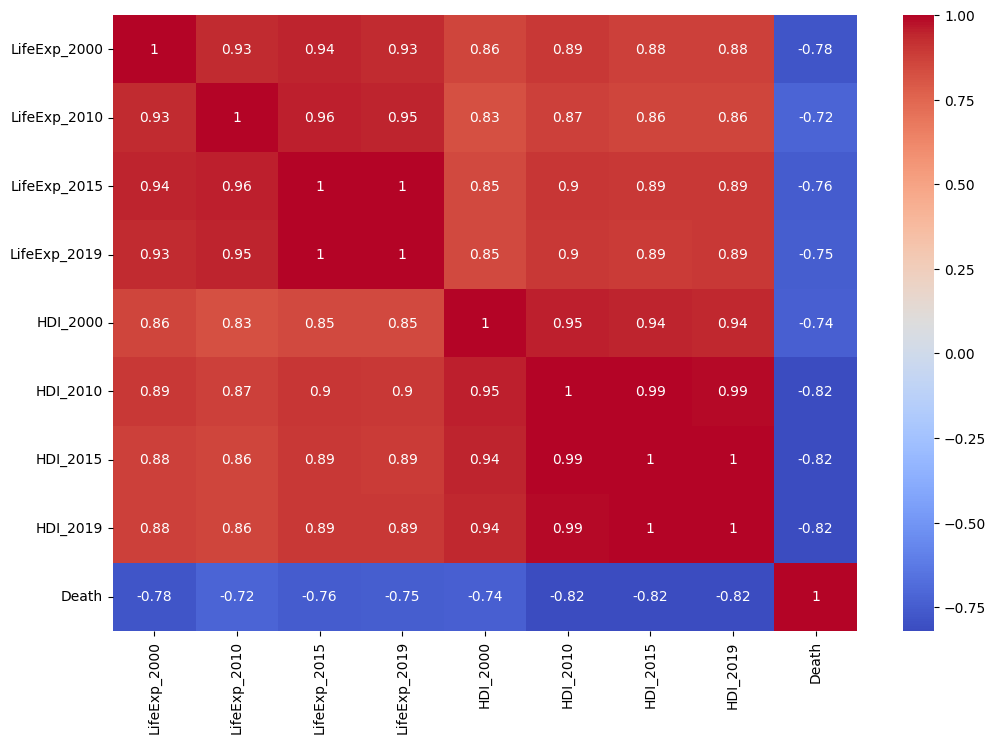

In [350]:
# Selecione as colunas relevantes para o cálculo da matriz de correlação.
colunas_selecionadas = ['LifeExp_2000', 'LifeExp_2010', 'LifeExp_2015', 'LifeExp_2019', 'HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019', 'Death']

# Crie um novo DataFrame contendo apenas as colunas selecionadas.
df_correlacao = merged_df_12[colunas_selecionadas]

# Calcule a matriz de correlação usando o método corr().
matriz_correlacao = df_correlacao.corr()

# Agora, matriz_correlacao contém as correlações entre as variáveis selecionadas nos anos desejados.

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap="coolwarm")
plt.show()

Podemos observar que as mortes pelo não uso do saneamento básico de forma apropriada, pode afetar a expectativa de vida nos paises. Apesar de existirem outros fatores externos que influenciam nisso. Além da correlação ser negativa. o que simboliza que, com o crescimento do IDH, a taxa de morte acaba diminuindo

## Teste de Hipótese

Hipótese nula(H0): Não há relação significativa entre a expectativa de vida, IDH e taxa de mortalidade por não uso do saneamento básico

Hipótese alternativa(H1): Existe uma relação significativa entre expectativa de vida, IDH e taxa de mortalidade por não uso do saneamento básico

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


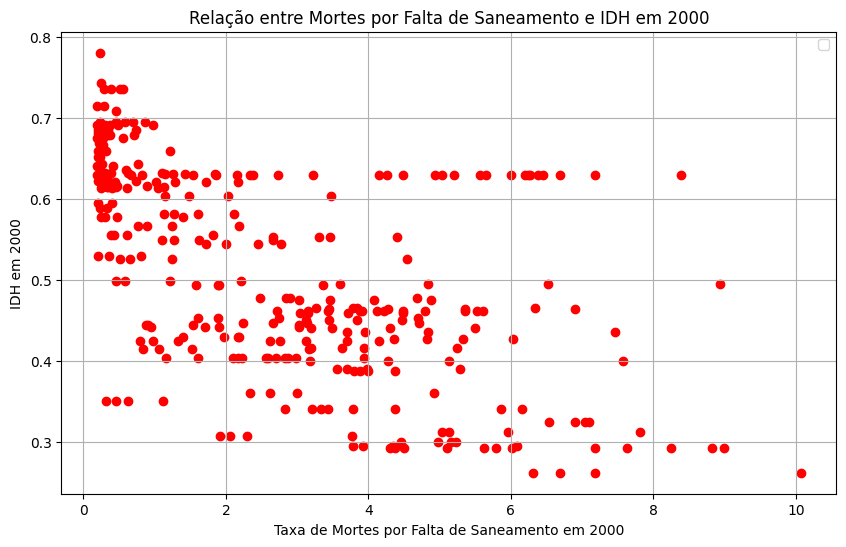

(-25.791688931655756, 4.9295919501755775e-101, 'Rejeitar a hipótese nula')

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Dividindo o dataset em dois grupos com base na mediana das mortes por falta de saneamento em 2000
mediana_mortes_2000 = merged_df_12['Death'].median()
grupo_alto_2000 = merged_df_12[merged_df_12['Death'] >= mediana_mortes_2000]
grupo_baixo_2000 = merged_df_12[merged_df_12['Death'] < mediana_mortes_2000]

# Teste T para IDH em 2000
t_stat_hdi_2000, p_value_hdi_2000 = stats.ttest_ind(grupo_alto_2000['HDI_2000'], grupo_baixo_2000['HDI_2000'])

# Teste T para Expectativa de Vida em 2000
t_stat_lifeexp_2000, p_value_lifeexp_2000 = stats.ttest_ind(grupo_alto_2000['LifeExp_2000'], grupo_baixo_2000['LifeExp_2000'])

# Nível de significância
alpha = 0.05

# Conclusão para IDH
if p_value_hdi_2000 < alpha:
    conclusao_hdi_2000 = "Rejeitar a hipótese nula"
else:
    conclusao_hdi_2000 = "Aceitar a hipótese nula"

# Conclusão para Expectativa de Vida
if p_value_lifeexp_2000 < alpha:
    conclusao_lifeexp_2000 = "Rejeitar a hipótese nula"
else:
    conclusao_lifeexp_2000 = "Aceitar a hipótese nula"

# Gráfico de Dispersão para 2000
plt.figure(figsize=(10, 6))
plt.scatter(grupo_alto_2000['Death'], grupo_alto_2000['HDI_2000'], color='red')
plt.xlabel('Taxa de Mortes por Falta de Saneamento em 2000')
plt.ylabel('IDH em 2000')
plt.title('Relação entre Mortes por Falta de Saneamento e IDH em 2000')
plt.legend()
plt.grid(True)
plt.show()

t_stat_hdi_2000, p_value_hdi_2000, conclusao_hdi_2000
t_stat_lifeexp_2000, p_value_lifeexp_2000, conclusao_lifeexp_2000


In [352]:
# Análise para HDI 2019
X = merged_df_12['Death']  # variável independente
Y = merged_df_12['HDI_2000']  # variável dependente
X = sm.add_constant(X)  # adicionar constante
model_hdi_2019 = sm.OLS(Y, X).fit()
print(model_hdi_2019.summary())

# Análise para LifeExp 2019
Y = merged_df_12['LifeExp_2000']  # variável dependente
model_lifeexp_2019 = sm.OLS(Y, X).fit()
print(model_lifeexp_2019.summary())

                            OLS Regression Results                            
Dep. Variable:               HDI_2000   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     768.9
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          1.17e-111
Time:                        14:59:32   Log-Likelihood:                 496.75
No. Observations:                 640   AIC:                            -989.5
Df Residuals:                     638   BIC:                            -980.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7126      0.005    133.877      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


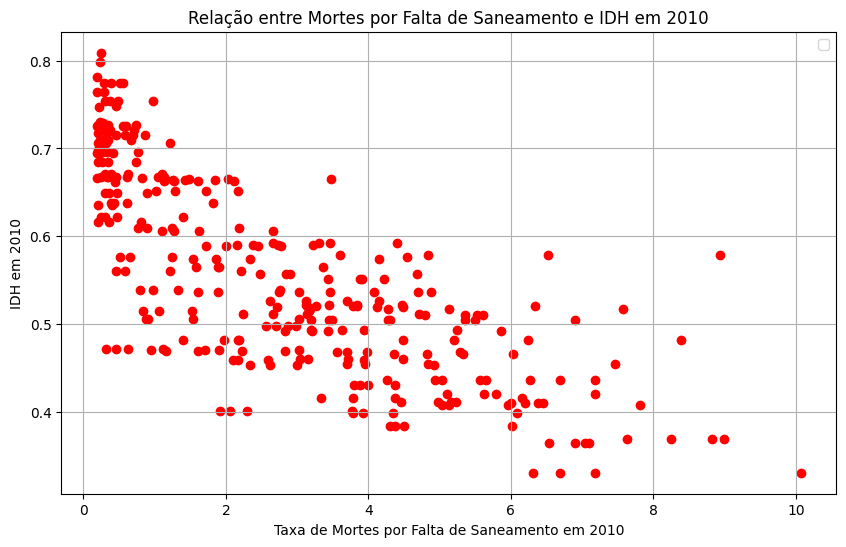

(-25.0817674537107, 3.9118581198536703e-97, 'Rejeitar a hipótese nula')

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Dividindo o dataset em dois grupos com base na mediana das mortes por falta de saneamento em 2000
mediana_mortes_2010 = merged_df_12['Death'].median()
grupo_alto_2010 = merged_df_12[merged_df_12['Death'] >= mediana_mortes_2010]
grupo_baixo_2010 = merged_df_12[merged_df_12['Death'] < mediana_mortes_2010]

# Teste T para IDH em 2000
t_stat_hdi_2010, p_value_hdi_2010 = stats.ttest_ind(grupo_alto_2000['HDI_2010'], grupo_baixo_2000['HDI_2010'])

# Teste T para Expectativa de Vida em 2000
t_stat_lifeexp_2010, p_value_lifeexp_2010 = stats.ttest_ind(grupo_alto_2000['LifeExp_2010'], grupo_baixo_2000['LifeExp_2010'])

# Nível de significância
alpha = 0.05

# Conclusão para IDH
if p_value_hdi_2010 < alpha:
    conclusao_hdi_2010 = "Rejeitar a hipótese nula"
else:
    conclusao_hdi_2010 = "Aceitar a hipótese nula"

# Conclusão para Expectativa de Vida
if p_value_lifeexp_2010 < alpha:
    conclusao_lifeexp_2010 = "Rejeitar a hipótese nula"
else:
    conclusao_lifeexp_2010 = "Aceitar a hipótese nula"

# Gráfico de Dispersão para 2000
plt.figure(figsize=(10, 6))
plt.scatter(grupo_alto_2000['Death'], grupo_alto_2000['HDI_2010'], color='red')
plt.xlabel('Taxa de Mortes por Falta de Saneamento em 2010')
plt.ylabel('IDH em 2010')
plt.title('Relação entre Mortes por Falta de Saneamento e IDH em 2010')
plt.legend()
plt.grid(True)
plt.show()

t_stat_hdi_2010, p_value_hdi_2010, conclusao_hdi_2010
t_stat_lifeexp_2010, p_value_lifeexp_2010, conclusao_lifeexp_2010


In [354]:
import statsmodels.api as sm

# Análise para HDI 2019
X = merged_df_12['Death']  # variável independente
Y = merged_df_12['HDI_2010']  # variável dependente
X = sm.add_constant(X)  # adicionar constante
model_hdi_2019 = sm.OLS(Y, X).fit()
print(model_hdi_2019.summary())

# Análise para LifeExp 2019
Y = merged_df_12['LifeExp_2010']  # variável dependente
model_lifeexp_2019 = sm.OLS(Y, X).fit()
print(model_lifeexp_2019.summary())

                            OLS Regression Results                            
Dep. Variable:               HDI_2010   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1315.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          4.20e-157
Time:                        14:59:33   Log-Likelihood:                 626.78
No. Observations:                 640   AIC:                            -1250.
Df Residuals:                     638   BIC:                            -1241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7712      0.004    177.526      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


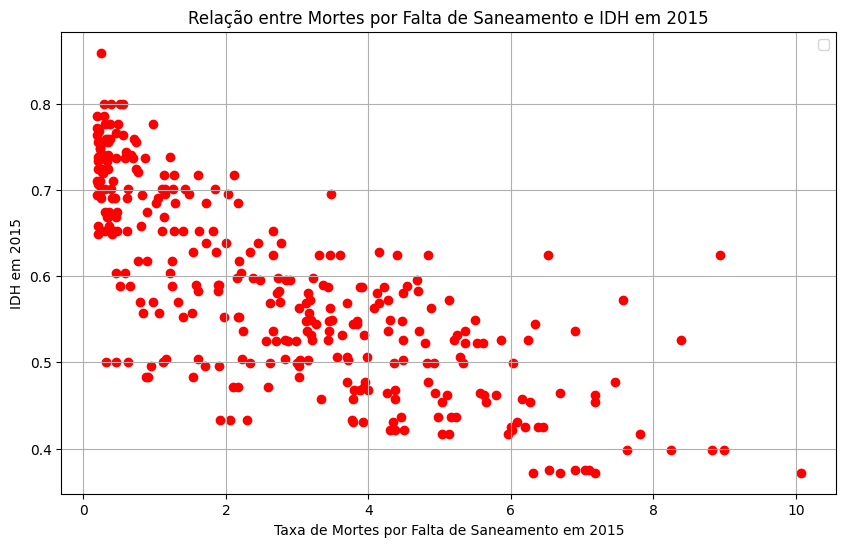

(-27.352344192277528, 1.3581682570158195e-109, 'Rejeitar a hipótese nula')

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Dividindo o dataset em dois grupos com base na mediana das mortes por falta de saneamento em 2000
mediana_mortes_2015 = merged_df_12['Death'].median()
grupo_alto_2015 = merged_df_12[merged_df_12['Death'] >= mediana_mortes_2015]
grupo_baixo_2015 = merged_df_12[merged_df_12['Death'] < mediana_mortes_2015]

# Teste T para IDH em 2000
t_stat_hdi_2015, p_value_hdi_2015 = stats.ttest_ind(grupo_alto_2015['HDI_2015'], grupo_baixo_2015['HDI_2015'])

# Teste T para Expectativa de Vida em 2000
t_stat_lifeexp_2015, p_value_lifeexp_2015 = stats.ttest_ind(grupo_alto_2015['LifeExp_2015'], grupo_baixo_2015['LifeExp_2015'])

# Nível de significância
alpha = 0.05

# Conclusão para IDH
if p_value_hdi_2015 < alpha:
    conclusao_hdi_2015 = "Rejeitar a hipótese nula"
else:
    conclusao_hdi_2015 = "Aceitar a hipótese nula"

# Conclusão para Expectativa de Vida
if p_value_lifeexp_2015 < alpha:
    conclusao_lifeexp_2015 = "Rejeitar a hipótese nula"
else:
    conclusao_lifeexp_2015 = "Aceitar a hipótese nula"

# Gráfico de Dispersão para 2000
plt.figure(figsize=(10, 6))
plt.scatter(grupo_alto_2015['Death'], grupo_alto_2015['HDI_2015'], color='red')
plt.xlabel('Taxa de Mortes por Falta de Saneamento em 2015')
plt.ylabel('IDH em 2015')
plt.title('Relação entre Mortes por Falta de Saneamento e IDH em 2015')
plt.legend()
plt.grid(True)
plt.show()

t_stat_hdi_2015, p_value_hdi_2015, conclusao_hdi_2015
t_stat_lifeexp_2015, p_value_lifeexp_2015, conclusao_lifeexp_2015


In [356]:
import statsmodels.api as sm

# Análise para HDI 2019
X = merged_df_12['Death']  # variável independente
Y = merged_df_12['HDI_2015']  # variável dependente
X = sm.add_constant(X)  # adicionar constante
model_hdi_2019 = sm.OLS(Y, X).fit()
print(model_hdi_2019.summary())

# Análise para LifeExp 2019
Y = merged_df_12['LifeExp_2015']  # variável dependente
model_lifeexp_2019 = sm.OLS(Y, X).fit()
print(model_lifeexp_2019.summary())

                            OLS Regression Results                            
Dep. Variable:               HDI_2015   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     1274.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          3.48e-154
Time:                        14:59:34   Log-Likelihood:                 641.16
No. Observations:                 640   AIC:                            -1278.
Df Residuals:                     638   BIC:                            -1269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7921      0.004    186.490      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


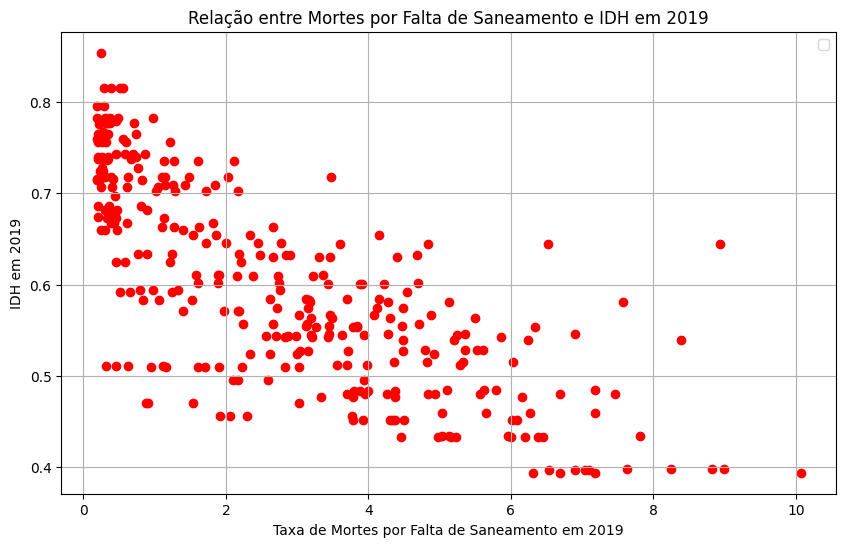

(-27.343242551101696, 1.5232936964467308e-109, 'Rejeitar a hipótese nula')

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Dividindo o dataset em dois grupos com base na mediana das mortes por falta de saneamento em 2000
mediana_mortes_2019 = merged_df_12['Death'].median()
grupo_alto_2019 = merged_df_12[merged_df_12['Death'] >= mediana_mortes_2019]
grupo_baixo_2019 = merged_df_12[merged_df_12['Death'] < mediana_mortes_2019]

# Teste T para IDH em 2000
t_stat_hdi_2019, p_value_hdi_2019 = stats.ttest_ind(grupo_alto_2019['HDI_2019'], grupo_baixo_2019['HDI_2019'])

# Teste T para Expectativa de Vida em 2000
t_stat_lifeexp_2019, p_value_lifeexp_2019 = stats.ttest_ind(grupo_alto_2019['LifeExp_2019'], grupo_baixo_2019['LifeExp_2019'])

# Nível de significância
alpha = 0.05

# Conclusão para IDH
if p_value_hdi_2019 < alpha:
    conclusao_hdi_2019 = "Rejeitar a hipótese nula"
else:
    conclusao_hdi_2019 = "Aceitar a hipótese nula"

# Conclusão para Expectativa de Vida
if p_value_lifeexp_2019 < alpha:
    conclusao_lifeexp_2019 = "Rejeitar a hipótese nula"
else:
    conclusao_lifeexp_2019 = "Aceitar a hipótese nula"

# Gráfico de Dispersão para 2000
plt.figure(figsize=(10, 6))
plt.scatter(grupo_alto_2019['Death'], grupo_alto_2019['HDI_2019'], color='red')
plt.xlabel('Taxa de Mortes por Falta de Saneamento em 2019')
plt.ylabel('IDH em 2019')
plt.title('Relação entre Mortes por Falta de Saneamento e IDH em 2019')
plt.legend()
plt.grid(True)
plt.show()

t_stat_hdi_2019, p_value_hdi_2019, conclusao_hdi_2019
t_stat_lifeexp_2019, p_value_lifeexp_2019, conclusao_lifeexp_2019


In [358]:

# Análise para HDI 2019
X = merged_df_12['Death']  # variável independente
Y = merged_df_12['HDI_2019']  # variável dependente
X = sm.add_constant(X)  # adicionar constante
model_hdi_2019 = sm.OLS(Y, X).fit()
print(model_hdi_2019.summary())

# Análise para LifeExp 2019
Y = merged_df_12['LifeExp_2019']  # variável dependente
model_lifeexp_2019 = sm.OLS(Y, X).fit()
print(model_lifeexp_2019.summary())

                            OLS Regression Results                            
Dep. Variable:               HDI_2019   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     1278.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          1.79e-154
Time:                        14:59:34   Log-Likelihood:                 647.31
No. Observations:                 640   AIC:                            -1291.
Df Residuals:                     638   BIC:                            -1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8038      0.004    191.058      0.0

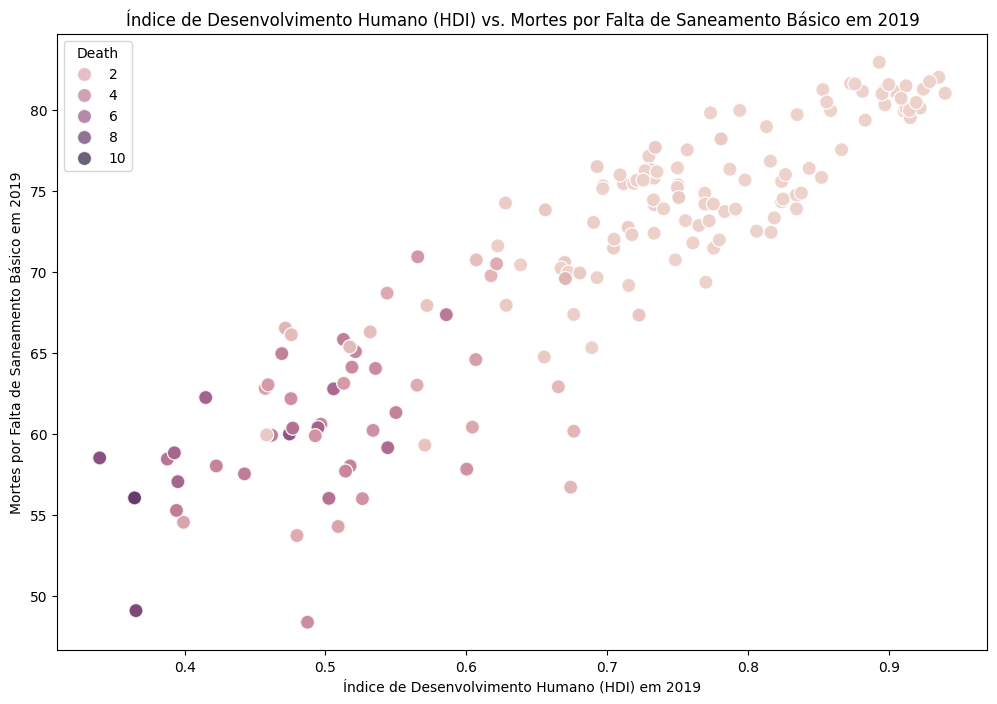

In [359]:
# Filtre o DataFrame para conter apenas os dados de 2019.

anos_interesse = [2000, 2010, 2015, 2019]
df_anos_interesse = merged_df_12[merged_df_12['Year'].isin(anos_interesse)]
df_anos_interesse['Media_LifeExp'] = df_anos_interesse[['LifeExp_2000', 'LifeExp_2010', 'LifeExp_2015', 'LifeExp_2019']].mean(axis=1)
df_anos_interesse['Media_HDI'] = df_anos_interesse[['HDI_2000', 'HDI_2010', 'HDI_2015', 'HDI_2019']].mean(axis=1)

# Crie o gráfico de dispersão.
plt.figure(figsize=(12, 8))

# Use o método scatter do matplotlib para criar o gráfico.
scatter = sns.scatterplot(x='Media_HDI', y='Media_LifeExp', hue='Death', data=df_anos_interesse, s=100, alpha=0.7)

# Defina os rótulos dos eixos e o título.
plt.title('Índice de Desenvolvimento Humano (HDI) vs. Mortes por Falta de Saneamento Básico em 2019')
plt.xlabel('Índice de Desenvolvimento Humano (HDI) em 2019')
plt.ylabel('Mortes por Falta de Saneamento Básico em 2019')

# Exiba o gráfico.
plt.show()



## Regressão Linear

In [360]:
from sklearn.preprocessing import StandardScaler

X = df_anos_interesse['Media_LifeExp'].values.reshape(-1,1) # Variáveis independentes
y = df_anos_interesse['Media_HDI'].values.reshape(-1,1) # Variável dependente

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Adicionando uma constante ao modelo
X = sm.add_constant(X_scaled)

# Criando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibindo os resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     2786.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          5.96e-235
Time:                        14:59:35   Log-Likelihood:                 819.17
No. Observations:                 640   AIC:                            -1634.
Df Residuals:                     638   BIC:                            -1625.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6849      0.003    257.114      0.0

In [361]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=20)

# Criando o modelo de regressão linear
modelo = LinearRegression()

# Ajustando o modelo aos dados de treino
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# Bootstrap
n_bootstraps = 1000
coeficientes = []
interceptos = []
mse_values = []

for _ in range(n_bootstraps):
    indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_train_bs = X_train[indices]
    y_train_bs = y_train[indices]

    # Ajustar o modelo
    modelo_bs = LinearRegression().fit(X_train_bs, y_train_bs)
    coeficientes.append(modelo_bs.coef_[0])
    interceptos.append(modelo_bs.intercept_)
    
    # Prever e calcular o MSE
    y_pred_bs = modelo_bs.predict(X_test)
    mse_values.append(mean_squared_error(y_test, y_pred_bs))

# Calculando os intervalos de confiança
confianca_intervalo_coef = np.percentile(coeficientes, [2.5, 97.5], axis=0)
confianca_intervalo_intercept = np.percentile(interceptos, [2.5, 97.5])
confianca_intervalo_mse = np.percentile(mse_values, [2.5, 97.5])

print(f'Coefficient: {modelo.coef_[0][1]}')
print(f'Intercept: {modelo.intercept_}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}' )
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}' )
print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'95% Intervalo de confiança para o intercepto: {confianca_intervalo_intercept}')
print(f'95% Intervalo de confiança para o MSE: {confianca_intervalo_mse}')


Coefficient: 0.1433521821037667
Intercept: [0.68385374]
Mean squared error: 0.01
Mean absolute error: 0.06
R2: 0.77
95% Intervalo de confiança para o intercepto: [0.67826568 0.68953168]
95% Intervalo de confiança para o MSE: [0.0054874  0.00595552]


### O que o modelo nos diz?


Relação Positiva: Existe uma relação positiva entre o HDI e a expectativa de vida média, o que significa que países com um HDI mais alto tendem a ter uma expectativa de vida maior.

Força da Relação: A inclinação da linha de regressão sugere que a relação entre o HDI e a expectativa de vida é relativamente forte – pequenos aumentos no HDI estão associados a aumentos significativos na expectativa de vida.

Variância Explicada: A linha de regressão parece passar perto da maioria dos pontos de dados, o que pode indicar que o modelo tem uma boa capacidade de explicar a variância nos dados. No entanto, para uma análise mais precisa, você precisaria olhar para métricas como o coeficiente de determinação R².

Dispersão dos Dados: Alguns pontos estão distantes da linha de regressão, o que indica que existem variações na expectativa de vida que não são totalmente explicadas pelo HDI. Isso pode ser devido a outros fatores que não são considerados neste modelo.

Média de Mortes: O tamanho dos pontos indica a média de mortes, e parece haver uma concentração de pontos maiores em HDIs mais baixos, sugerindo que países com menor HDI podem ter uma taxa de mortalidade mais alta.

Intervalo de Confiança: A área sombreada ao redor da linha de regressão indica o intervalo de confiança. Quanto mais estreita a sombra, mais confiante podemos estar na nossa previsão da expectativa de vida baseada no HDI.

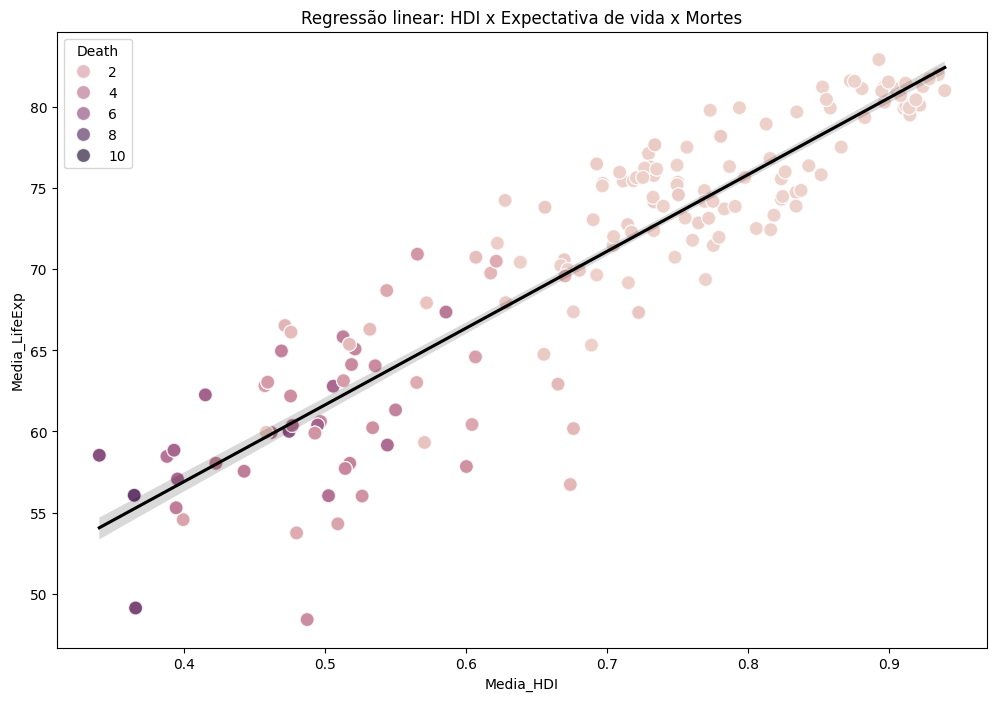

In [362]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Media_HDI', y='Media_LifeExp', hue='Death', data=df_anos_interesse, s=100, alpha=0.7)
# Agora, adicione uma linha de regressão geral (sem coloração por 'Death')
sns.regplot(x='Media_HDI', y='Media_LifeExp', data=df_anos_interesse, scatter=False, color='black')
plt.title('Regressão linear: HDI x Expectativa de vida x Mortes')
plt.show()

Coeficient : Este valor indica a mudança esperada na variável dependente (presumivelmente 'Media_HDI' no seu caso) para um aumento de uma unidade na variável independente ('Media_LifeExp'). Um coeficiente de 0.14335218 sugere que, para cada unidade adicional na expectativa média de vida, o Índice de Desenvolvimento Humano aumenta em 0.14335218, mantendo-se tudo mais constante.

Intercepto: O intercepto representa o valor esperado da variável dependente quando todas as variáveis independentes são iguais a zero. No contexto do modelo, isso significa que quando a 'Media_LifeExp' é 0, o valor esperado de 'Media_HDI' seria aproximadamente 0.684. Em outras palavras, ele fornece um ponto de partida (baseline) para as previsões do modelo.

Mean Squared Error (MSE): O MSE é uma medida da qualidade do modelo e representa a média dos quadrados das diferenças entre os valores observados e previstos. Um MSE de 0.01 é relativamente baixo, o que indica que o modelo tem um bom ajuste geral aos dados.

Mean Absolute Error (MAE): O MAE é a média do valor absoluto dos erros. Um MAE de 0.06 indica que, em média, as previsões do modelo desviam-se em 0.06 unidades do valor real. Assim como o MSE, a interpretação do MAE depende da escala dos dados.

R²: O coeficiente R² varia entre 0 e 1 e mede a proporção da variância na variável dependente que pode ser explicada pelas variáveis independentes no modelo. Um R² de 0.77 significa que 77% da variância em 'Media_HDI' é explicada pela variável 'Media_LifeExp'. Este é um valor relativamente alto, indicando que o modelo tem um bom poder explicativo.

# Conclusão: Quais aspectos mais influenciam na expectativa de vida por países?

Aspectos de Saúde (Tabaco):

O R² de 0.064 sugere que a prevalência do tabaco tem uma influência relativamente baixa na expectativa de vida. O intervalo de confiança para o coeficiente varia de -0.161 a 0.685, indicando incerteza sobre a direção e magnitude da influência. O intervalo de confiança para o R² também é amplo, reforçando a incerteza sobre a influência do tabaco.
Coeficiente de Gini (Desigualdade Social):

Coeficiente de Gini:

Com um R² de 0.15, a desigualdade social, medida pelo coeficiente de Gini, tem um impacto modesto na expectativa de vida. O coeficiente negativo sugere que maior desigualdade está associada a uma menor expectativa de vida.
PIB (Aspecto Econômico):

PIB:

O R² negativo de -0.36 é incomum e pode indicar problemas no modelo ou nos dados. Normalmente, um R² negativo sugere que o modelo não é adequado para os dados. No entanto, o coeficiente positivo sugere que um maior PIB está associado a uma maior expectativa de vida.
Saneamento Básico e IDH:

Saneamento Básico e IDH:

Um R² de 0.814 indica uma forte correlação entre saneamento básico/IDH e expectativa de vida. Isso sugere que melhorias no saneamento básico e no IDH estão fortemente associadas a uma maior expectativa de vida.
Conclusão:
Entre os aspectos analisados, o saneamento básico e o Índice de Desenvolvimento Humano (IDH) parecem ser os fatores mais influentes na expectativa de vida, seguidos por aspectos econômicos (medidos pelo PIB) e aspectos sociais (medidos pelo coeficiente de Gini). O impacto do consumo de tabaco na expectativa de vida é menos claro, dada a ampla variação nos intervalos de confiança e o baixo R².

É importante notar que essas análises são baseadas em modelos lineares e correlações, que podem não capturar completamente as complexas relações entre esses aspectos e a expectativa de vida. Além disso, outros fatores não considerados aqui também podem ter um papel significativo.

## R2 aspectos sociais
R² Score for HDI: 0.8326030081192164

R² Score for Unemployment: -0.07389699818714957
